## 1. Primero, necesitamos entender nuestra estructura de datos

In [107]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Supongamos que tu dataframe tiene esta estructura
# (Ajusta según tus variables reales)
def crear_estructura_ejemplo():
    data = {
        # Character
        'puntaje_credito': [750, 680, 820, 600, 710],
        'antiguedad_credito': [5, 2, 10, 1, 4],
        'historial_pagos': [1, 0, 1, 0, 1],  # 1=bueno, 0=malo
        
        # Capacity
        'ingreso_mensual': [5000, 3000, 8000, 2500, 4000],
        'dti': [0.25, 0.45, 0.15, 0.60, 0.35],
        'deuda_total': [10000, 15000, 5000, 20000, 12000],
        
        # Capital
        'ahorros': [20000, 5000, 50000, 1000, 15000],
        'inversiones': [15000, 2000, 100000, 500, 8000],
        'patrimonio_neto': [50000, 10000, 200000, 2000, 30000],
        
        # Collateral
        'valor_garantia': [30000, 15000, 80000, 8000, 25000],
        'ltv': [0.70, 0.85, 0.50, 0.95, 0.75],
        
        # Conditions
        'estabilidad_empleo': [3, 1, 5, 1, 2],  # años en el trabajo
        'sector_trabajo': ['servicios', 'construccion', 'tech', 'retail', 'salud'],
        
        # Variable objetivo (lo que quieres predecir)
        'incumplio': [0, 1, 0, 1, 0]  # 0=no incumplió, 1=incumplió
    }
    return pd.DataFrame(data)

def LeerBaseDatos():
    # === 1. Cargar datos ===
    ruta = "./../Registros_sin_nulos.csv"
    df = pd.read_csv(ruta)

    # === 2. Crear variable target ===
    df["target"] = df["diasmora"].apply(lambda x: 1 if x > 7 else 0)

    # Eliminar columnas que no se usarán
    df = df.drop(columns=["nosocio", "nocredito", "sucursal", "diasmora"], errors="ignore")

    return df
#df = crear_estructura_ejemplo()
df = LeerBaseDatos()
print("Estructura de datos de ejemplo:")
print(df.head())

Estructura de datos de ejemplo:
  clasificacion                        producto    monto  tasaordinaria  \
0       CONSUMO  CREDI-CONSUMO LACHAO CONFIANZA  20000.0           30.0   
1       CONSUMO          CREDI-PROMOCION LACHAO  15000.0           30.0   
2       CONSUMO  CREDI-CONSUMO LACHAO CONFIANZA   5000.0           30.0   
3       CONSUMO  CREDI-CONSUMO LACHAO CONFIANZA  10000.0           30.0   
4       CONSUMO  CREDI-CONSUMO LACHAO CONFIANZA  10000.0           30.0   

   tasamoratoria plazocredito  frecuenciacapint renovadoestructurado  \
0           60.0     18 MESES                30               NORMAL   
1           60.0     12 MESES                30               NORMAL   
2           60.0     12 MESES                30               NORMAL   
3           60.0     12 MESES                30               NORMAL   
4           60.0     12 MESES                30               NORMAL   

  vigentevencido  montogarantialiq  ...                                deudas  \
0  

## 2. Cálculo del Peso de cada C usando Machine Learning

In [108]:
def calcular_pesos_5c(df, variable_objetivo='target'):
    """
    Calcula la importancia de cada una de las 5 C's usando Random Forest
    """
    # Mapear variables a cada C
    variables_por_c = {
        "Carácter": ["reputación_localidad", "antigudad_domicilio", "antiguedad_actividad", "exp_cred_externa", "exp_cred_interna"],
        "Capacidad": ["cap_pago"],
        "Capital": ["tipo_casa", "deudas"],
        "Condiciones": ["permiso_para_funcionar", "comercio_en_region", "empleo"],
        "Colateral": ["solidario", "pro_comunal", "pro_privada","lÍquida"]
    }
    
    # Preparar datos
    X = df.drop(columns=[variable_objetivo])
    y = df[variable_objetivo]
    
    # Codificar variables categóricas
    X_encoded = pd.get_dummies(X)
    
    # Entrenar modelo
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_encoded, y)
    
    # Obtener importancia de características
    feature_importance = pd.DataFrame({
        'feature': X_encoded.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Agrupar importancia por C
    importancia_c = {}
    for c, variables in variables_por_c.items():
        # Buscar variables que coincidan (incluyendo dummies)
        relevant_features = [f for f in feature_importance['feature'] 
                           if any(var in f for var in variables)]
        
        importancia_c[c] = feature_importance[
            feature_importance['feature'].isin(relevant_features)
        ]['importance'].sum()
    
    # Normalizar a porcentaje
    total = sum(importancia_c.values())
    importancia_porcentaje = {k: (v/total)*100 for k, v in importancia_c.items()}
    
    return importancia_porcentaje, feature_importance, variables_por_c

# Calcular pesos
pesos_c, importancia_features, variables_por_c = calcular_pesos_5c(df)

In [109]:
def feature_engineering_credito(df):
    """
    Feature engineering específico para riesgo crediticio
    """
    df_eng = df.copy()
    
    # 1. RATIOS FINANCIEROS Y DE CAPACIDAD DE PAGO
    # Ratio deuda/ingresos (simulado)
    if 'ingresos_ordinarios' in df.columns and 'deudas' in df.columns:
        # Convertir deudas a numérico si es categórico
        if df['deudas'].dtype == 'object':
            deudas_map = {
                'SIN DEUDAS': 0,
                'DEUDAS DEL 1% AL 20% DEL PATRIMONIO': 0.1,
                'DEUDAS DEL 21% AL 40% DEL PATRIMONIO': 0.3,
                'DEUDAS DEL 41% AL 60% DEL PATRIMONIO': 0.5,
                'DEUDAS MAYORES AL 60% DEL PATRIMONIO': 0.8
            }
            df_eng['deudas_numeric'] = df['deudas'].map(deudas_map)
            df_eng['deuda_ingreso_ratio'] = df_eng['deudas_numeric'] / (df['ingresos_ordinarios'] + 1e-6)
        else:
            df_eng['deuda_ingreso_ratio'] = df['deudas'] / (df['ingresos_ordinarios'] + 1e-6)
    
    # 2. INTERACCIONES ENTRE VARIABLES
    if 'monto' in df.columns and 'ingresos_ordinarios' in df.columns:
        df_eng['monto_ingreso_ratio'] = df['monto'] / (df['ingresos_ordinarios'] + 1e-6)
    
    if 'montogarantialiq' in df.columns and 'monto' in df.columns:
        df_eng['cobertura_garantia'] = df['montogarantialiq'] / (df['monto'] + 1e-6)
    
    # 3. VARIABLES TEMPORALES Y COMPORTAMIENTO
    if 'plazocredito' in df.columns:
        # Convertir plazocredito a numérico
        if df['plazocredito'].dtype == 'object':
            df_eng['plazo_meses'] = df['plazocredito'].str.extract('(\d+)').astype(float)
        else:
            df_eng['plazo_meses'] = df['plazocredito']
    
    # 4. SCORING COMPUESTO DE HISTORIAL CREDITICIO
    historial_map = {
        'PAGO PUNTUAL(CALIF. A)': 1.0,
        'HASTA 5 ATRASOS MENORES DE 7 DIAS(CALIF. B)': 0.6,
        'MAS DE 5 ATRASOS MENORES DE 7 DIAS(CALIF. C)': 0.3,
        'ATRASOS MAYORES A 7 DIAS(CALIF. D)': 0.1
    }
    
    if 'exp_cred_interna' in df.columns:
        df_eng['score_historial_interno'] = df['exp_cred_interna'].map(
            lambda x: historial_map.get(x, 0.5) if pd.notna(x) else 0.5
        )
    
    # 5. VARIABLES DE ESTABILIDAD
    if 'empleo' in df.columns:
        estabilidad_map = {
            'EMPLEO PERMANENTE': 1.0,
            'EMPLEO TEMPORAL': 0.6,
            'INDEPENDIENTE': 0.7,
            'DESEMPLEADO': 0.2
        }
        df_eng['estabilidad_empleo_score'] = df['empleo'].map(
            lambda x: estabilidad_map.get(x, 0.5) if pd.notna(x) else 0.5
        )
    
    # 6. VARIABLES DE DIVERSIFICACIÓN GEOGRÁFICA/COMERCIAL
    if 'comercio_en_region' in df.columns:
        df_eng['presencia_regional'] = df['comercio_en_region'].map({'SI': 1, 'NO': 0})
    
    # 7. SCORING COMPUESTO DE LAS 5Cs
    # Crear scores individuales para cada C
    scores_c = {}
    
    # Carácter
    caracter_vars = ['score_historial_interno', 'estabilidad_empleo_score']
    caracter_vars = [v for v in caracter_vars if v in df_eng.columns]
    if caracter_vars:
        df_eng['score_caracter'] = df_eng[caracter_vars].mean(axis=1)
        scores_c['Carácter'] = caracter_vars
    
    # Capacidad
    capacidad_vars = ['deuda_ingreso_ratio', 'monto_ingreso_ratio']
    capacidad_vars = [v for v in capacidad_vars if v in df_eng.columns]
    if capacidad_vars:
        # Invertir ratios (menor ratio = mejor capacidad)
        for var in ['deuda_ingreso_ratio', 'monto_ingreso_ratio']:
            if var in df_eng.columns:
                df_eng[f'score_{var}'] = 1 / (df_eng[var] + 0.01)
        df_eng['score_capacidad'] = df_eng[[f'score_{v}' for v in capacidad_vars if f'score_{v}' in df_eng.columns]].mean(axis=1)
        scores_c['Capacidad'] = capacidad_vars
    
    # Colateral
    colateral_vars = ['cobertura_garantia']
    colateral_vars = [v for v in colateral_vars if v in df_eng.columns]
    if colateral_vars:
        df_eng['score_colateral'] = df_eng[colateral_vars].mean(axis=1)
        scores_c['Colateral'] = colateral_vars
    
    print("Nuevas variables creadas:")
    print(f"- Ratios financieros: {[col for col in df_eng.columns if 'ratio' in col.lower()]}")
    print(f"- Scores: {[col for col in df_eng.columns if 'score' in col.lower()]}")
    
    return df_eng, scores_c

# Aplicar feature engineering
df_enhanced, scores_por_c = feature_engineering_credito(df)
print("\nDataFrame después del feature engineering:")
print(df_enhanced.head())

Nuevas variables creadas:
- Ratios financieros: ['deuda_ingreso_ratio', 'monto_ingreso_ratio', 'score_deuda_ingreso_ratio', 'score_monto_ingreso_ratio']
- Scores: ['score_historial_interno', 'estabilidad_empleo_score', 'score_caracter', 'score_deuda_ingreso_ratio', 'score_monto_ingreso_ratio', 'score_capacidad', 'score_colateral']

DataFrame después del feature engineering:
  clasificacion                        producto    monto  tasaordinaria  \
0       CONSUMO  CREDI-CONSUMO LACHAO CONFIANZA  20000.0           30.0   
1       CONSUMO          CREDI-PROMOCION LACHAO  15000.0           30.0   
2       CONSUMO  CREDI-CONSUMO LACHAO CONFIANZA   5000.0           30.0   
3       CONSUMO  CREDI-CONSUMO LACHAO CONFIANZA  10000.0           30.0   
4       CONSUMO  CREDI-CONSUMO LACHAO CONFIANZA  10000.0           30.0   

   tasamoratoria plazocredito  frecuenciacapint renovadoestructurado  \
0           60.0     18 MESES                30               NORMAL   
1           60.0     12 MESE

In [110]:
def calcular_valor_detallado_5c(df, variable_objetivo='target'):
    """
    Calcula el valor detallado de cada característica para cada una de las 5 Cs
    """
    
    # Mapeo de variables a cada C (expandido)
    variables_por_c = {
        "Carácter": ["reputación_localidad", "antigudad_domicilio", "antiguedad_actividad", "exp_cred_externa", "exp_cred_interna"],
        "Capacidad": ["cap_pago"],
        "Capital": ["tipo_casa", "deudas"],
        "Condiciones": ["permiso_para_funcionar", "comercio_en_region", "empleo"],
        "Colateral": ["montogarantialiq", "montogarantiapre", "montogarantiahipo"]
    }
    
    # Filtrar variables que existen en el dataframe
    variables_por_c = {c: [v for v in vars_list if v in df.columns] 
                      for c, vars_list in variables_por_c.items()}
    
    # Preparar datos
    X = df.drop(columns=[variable_objetivo] if variable_objetivo in df.columns else [])
    y = df[variable_objetivo] if variable_objetivo in df.columns else None
    
    # Codificar variables categóricas
    X_encoded = pd.get_dummies(X)
    
    # Entrenar modelo
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_encoded, y)
    
    # Obtener importancia de características
    feature_importance = pd.DataFrame({
        'feature': X_encoded.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Calcular importancia detallada por C y por variable
    resultados_detallados = {}
    
    for c, variables in variables_por_c.items():
        print(f"\n=== {c} ===")
        c_results = {}
        total_c_importance = 0
        
        for variable in variables:
            # Buscar todas las características relacionadas con esta variable
            relevant_features = []
            
            # Para variables originales
            if variable in X.columns:
                if X[variable].dtype == 'object':
                    # Variables categóricas (dummies)
                    relevant_features = [f for f in feature_importance['feature'] 
                                       if f.startswith(f"{variable}_")]
                else:
                    # Variables numéricas
                    relevant_features = [variable]
            
            # Para variables de feature engineering
            elif variable in X_encoded.columns:
                relevant_features = [variable]
            
            # Calcular importancia total de la variable
            if relevant_features:
                var_importance = feature_importance[
                    feature_importance['feature'].isin(relevant_features)
                ]['importance'].sum()
                
                total_c_importance += var_importance
                c_results[variable] = {
                    'importancia': var_importance,
                    'caracteristicas': relevant_features,
                    'importancia_promedio_por_feature': var_importance / len(relevant_features)
                }
                
                print(f"  {variable}: {var_importance:.4f} ({len(relevant_features)} features)")
        
        # Calcular porcentajes dentro de la C
        for var_name, var_info in c_results.items():
            if total_c_importance > 0:
                porcentaje_dentro_c = (var_info['importancia'] / total_c_importance) * 100
            else:
                porcentaje_dentro_c = 0
            c_results[var_name]['porcentaje_dentro_c'] = porcentaje_dentro_c
        
        resultados_detallados[c] = {
            'variables': c_results,
            'importancia_total': total_c_importance,
            'numero_variables': len(c_results)
        }
    
    # Calcular importancia total y porcentajes globales
    importancia_total_global = sum([info['importancia_total'] for info in resultados_detallados.values()])
    
    for c, info in resultados_detallados.items():
        if importancia_total_global > 0:
            porcentaje_global = (info['importancia_total'] / importancia_total_global) * 100
        else:
            porcentaje_global = 0
        resultados_detallados[c]['porcentaje_global'] = porcentaje_global
    
    return resultados_detallados, feature_importance, variables_por_c

# Calcular valores detallados
resultados_detallados, importancia_features, variables_por_c = calcular_valor_detallado_5c(df_enhanced)


=== Carácter ===
  antigudad_domicilio: 0.0152 (4 features)
  antiguedad_actividad: 0.0305 (4 features)
  exp_cred_externa: 0.0017 (4 features)
  exp_cred_interna: 0.0166 (4 features)

=== Capacidad ===
  cap_pago: 0.0111 (4 features)

=== Capital ===
  tipo_casa: 0.0216 (3 features)
  deudas: 0.0197 (5 features)

=== Condiciones ===
  permiso_para_funcionar: 0.0161 (2 features)
  comercio_en_region: 0.0008 (2 features)
  empleo: 0.0025 (2 features)

=== Colateral ===
  montogarantialiq: 0.0293 (1 features)
  montogarantiapre: 0.0056 (1 features)
  montogarantiahipo: 0.0000 (1 features)


## 3. Visualización de Resultados

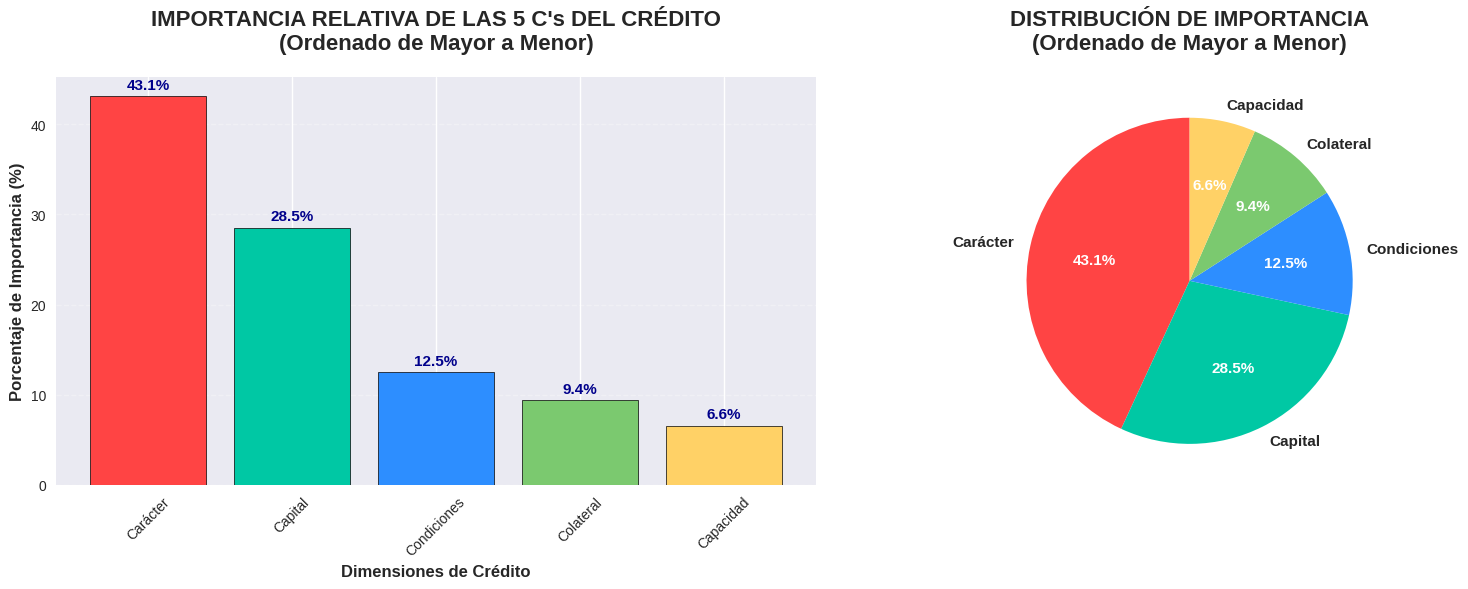

🔍 PESOS CALCULADOS (Ordenados de Mayor a Menor):
 1. Carácter     ████████              43.11%
 2. Capital      █████                 28.52%
 3. Condiciones  ██                    12.47%
 4. Colateral    █                      9.35%
 5. Capacidad    █                      6.55%
📊 TOTAL: 100.00%

💡 ANÁLISIS:
   • Dimensión más importante: Carácter (43.1%)
   • Dimensión menos importante: Capacidad (6.6%)
   • Diferencia: 36.6 puntos porcentuales
   ⚠️  Alta concentración en Carácter - considerar balancear criterios


In [111]:
def visualizar_pesos(pesos_c):
    """Visualiza la importancia de cada C ordenada de mayor a menor con más detalles"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Ordenar los pesos de mayor a menor
    pesos_ordenados = dict(sorted(pesos_c.items(), key=lambda x: x[1], reverse=True))
    categorias = list(pesos_ordenados.keys())
    valores = list(pesos_ordenados.values())
    
    # Colores degradados (más intenso para mayor importancia)
    colores = ['#FF4444', '#00C8A4', '#2D8EFF', '#7BC96F', '#FFD166']
    
    # Gráfico de barras
    barras = ax1.bar(categorias, valores, color=colores, edgecolor='black', linewidth=0.5)
    ax1.set_title('IMPORTANCIA RELATIVA DE LAS 5 C\'s DEL CRÉDITO\n(Ordenado de Mayor a Menor)', 
                 fontsize=16, fontweight='bold', pad=20)
    ax1.set_ylabel('Porcentaje de Importancia (%)', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Dimensiones de Crédito', fontsize=12, fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Añadir valores en las barras
    for barra, valor in zip(barras, valores):
        altura = barra.get_height()
        ax1.text(barra.get_x() + barra.get_width()/2., altura + 0.5,
                f'{valor:.1f}%', ha='center', va='bottom', 
                fontweight='bold', fontsize=11, color='darkblue')
    
    # Mejorar aspecto del gráfico
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    # Gráfico de pie
    wedges, texts, autotexts = ax2.pie(valores, labels=categorias, autopct='%1.1f%%', 
                                      startangle=90, colors=colores, 
                                      textprops={'fontsize': 11, 'fontweight': 'bold'})
    
    # Mejorar etiquetas del pie
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    ax2.set_title('DISTRIBUCIÓN DE IMPORTANCIA\n(Ordenado de Mayor a Menor)', 
                 fontsize=16, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Imprimir resultados ordenados con formato mejorado
    print("🔍 PESOS CALCULADOS (Ordenados de Mayor a Menor):")
    print("="*50)
    total = sum(valores)
    
    for i, (c, peso) in enumerate(pesos_ordenados.items(), 1):
        proporcion = peso / total * 100
        barra = "█" * int(peso / 5)  # Cada █ representa 5%
        print(f"{i:2d}. {c:12} {barra:20} {peso:6.2f}%")
    
    print("="*50)
    print(f"📊 TOTAL: {total:.2f}%")
    
    # Análisis adicional
    mayor = categorias[0]
    menor = categorias[-1]
    diferencia = valores[0] - valores[-1]
    
    print(f"\n💡 ANÁLISIS:")
    print(f"   • Dimensión más importante: {mayor} ({valores[0]:.1f}%)")
    print(f"   • Dimensión menos importante: {menor} ({valores[-1]:.1f}%)")
    print(f"   • Diferencia: {diferencia:.1f} puntos porcentuales")
    
    if diferencia > 30:
        print(f"   ⚠️  Alta concentración en {mayor} - considerar balancear criterios")
    elif diferencia < 10:
        print(f"   ✅ Buen balance entre dimensiones")

visualizar_pesos(pesos_c)

## 4. Análisis de Valores Óptimos por Variable

In [112]:
def analizar_valores_optimos_robusto(df, variable_objetivo='target', min_casos=5):
    """
    Versión más robusta que maneja diferentes tipos de variables
    """
    resultados = {}
    
    for columna in df.select_dtypes(include=[np.number]).columns:
        if columna == variable_objetivo:
            continue
            
        print(f"\n🔍 Analizando: {columna}")
        
        # Filtrar valores nulos
        datos_validos = df[[columna, variable_objetivo]].dropna()
        if len(datos_validos) < min_casos:
            print(f"   ⚠️  Muy pocos datos válidos ({len(datos_validos)}), saltando...")
            continue
            
        valores_unicos = datos_validos[columna].nunique()
        print(f"   Valores únicos: {valores_unicos}")
        
        if valores_unicos <= 3:
            # Análisis por categorías (variables binarias o con pocos valores)
            analisis_categorico(datos_validos, columna, variable_objetivo, resultados)
            
        elif valores_unicos <= 10:
            # Análisis por deciles para variables con más valores
            analisis_deciles(datos_validos, columna, variable_objetivo, resultados, n_groups=min(5, valores_unicos))
            
        else:
            # Análisis por quintiles para variables continuas
            analisis_quintiles(datos_validos, columna, variable_objetivo, resultados)
    
    return resultados

def analisis_categorico(datos, columna, variable_objetivo, resultados):
    """Análisis para variables categóricas/booleanas"""
    metricas = datos.groupby(columna).agg({
        variable_objetivo: ['mean', 'count', 'std']
    }).round(4)
    
    # Encontrar categoría con menor incumplimiento
    if len(metricas) > 0:
        mejor_categoria = metricas[(variable_objetivo, 'mean')].idxmin()
        mejor_metricas = metricas.loc[mejor_categoria]
        
        resultados[columna] = {
            'valor_optimo': mejor_categoria,
            'tasa_incumplimiento': mejor_metricas[(variable_objetivo, 'mean')],
            'cantidad_casos': mejor_metricas[(variable_objetivo, 'count')],
            'desviacion_std': mejor_metricas[(variable_objetivo, 'std')],
            'tipo_analisis': 'categorico',
            'todas_categorias': metricas[(variable_objetivo, 'mean')].to_dict()
        }
        print(f"   ✅ Análisis categórico completado")

def analisis_deciles(datos, columna, variable_objetivo, resultados, n_groups=5):
    """Análisis para variables con pocos valores únicos"""
    try:
        # Crear grupos basados en valores únicos
        datos_temp = datos.copy()
        datos_temp['grupo'] = pd.cut(datos_temp[columna], bins=n_groups, labels=False)
        
        metricas = datos_temp.groupby('grupo').agg({
            variable_objetivo: ['mean', 'count'],
            columna: ['min', 'max']
        }).round(4)
        
        if len(metricas) > 0:
            mejor_grupo = metricas[(variable_objetivo, 'mean')].idxmin()
            mejor_rango = metricas.loc[mejor_grupo]
            
            resultados[columna] = {
                'min': mejor_rango[(columna, 'min')],
                'max': mejor_rango[(columna, 'max')],
                'tasa_incumplimiento': mejor_rango[(variable_objetivo, 'mean')],
                'cantidad_casos': mejor_rango[(variable_objetivo, 'count')],
                'grupo': mejor_grupo + 1,
                'tipo_analisis': f'deciles_{n_groups}'
            }
            print(f"   ✅ Análisis por {n_groups} grupos completado")
            
    except Exception as e:
        print(f"   ❌ Error en análisis deciles: {e}")

def analisis_quintiles(datos, columna, variable_objetivo, resultados):
    """Análisis para variables continuas con quintiles"""
    try:
        datos_temp = datos.copy()
        datos_temp['quintil'] = pd.qcut(
            datos_temp[columna], 
            q=5, 
            labels=False, 
            duplicates='drop'
        )
        
        metricas = datos_temp.groupby('quintil').agg({
            variable_objetivo: ['mean', 'count'],
            columna: ['min', 'max', 'mean']
        }).round(4)
        
        if len(metricas) > 0:
            mejor_quintil = metricas[(variable_objetivo, 'mean')].idxmin()
            mejor_rango = metricas.loc[mejor_quintil]
            
            resultados[columna] = {
                'min': mejor_rango[(columna, 'min')],
                'max': mejor_rango[(columna, 'max')],
                'mean': mejor_rango[(columna, 'mean')],
                'tasa_incumplimiento': mejor_rango[(variable_objetivo, 'mean')],
                'cantidad_casos': mejor_rango[(variable_objetivo, 'count')],
                'quintil': mejor_quintil + 1,
                'tipo_analisis': 'quintiles'
            }
            print(f"   ✅ Análisis por quintiles completado")
            
    except Exception as e:
        print(f"   ❌ Error en análisis quintiles: {e}")

# Usar la versión robusta
print("=== ANÁLISIS ROBUSTO DE VALORES ÓPTIMOS ===")
valores_optimos = analizar_valores_optimos_robusto(df)

=== ANÁLISIS ROBUSTO DE VALORES ÓPTIMOS ===

🔍 Analizando: monto
   Valores únicos: 508
   ✅ Análisis por quintiles completado

🔍 Analizando: tasaordinaria
   Valores únicos: 30
   ✅ Análisis por quintiles completado

🔍 Analizando: tasamoratoria
   Valores únicos: 30
   ✅ Análisis por quintiles completado

🔍 Analizando: frecuenciacapint
   Valores únicos: 2
   ✅ Análisis categórico completado

🔍 Analizando: montogarantialiq
   Valores únicos: 88
   ✅ Análisis por quintiles completado

🔍 Analizando: montogarantiapre
   Valores únicos: 45
   ✅ Análisis por quintiles completado

🔍 Analizando: montogarantiahipo
   Valores únicos: 1
   ✅ Análisis categórico completado

🔍 Analizando: codigo_postal
   Valores únicos: 69
   ✅ Análisis por quintiles completado

🔍 Analizando: cod_actividad
   Valores únicos: 205
   ✅ Análisis por quintiles completado

🔍 Analizando: ingresos_ordinarios
   Valores únicos: 615
   ✅ Análisis por quintiles completado

🔍 Analizando: num_dependientes
   Valores únicos:

In [113]:
valores_optimos

{'monto': {'min': np.float64(1374.0),
  'max': np.float64(15000.0),
  'mean': np.float64(10433.236),
  'tasa_incumplimiento': np.float64(0.0199),
  'cantidad_casos': np.float64(3169.0),
  'quintil': np.int64(1),
  'tipo_analisis': 'quintiles'},
 'tasaordinaria': {'min': np.float64(12.0),
  'max': np.float64(30.0),
  'mean': np.float64(28.4031),
  'tasa_incumplimiento': np.float64(0.0331),
  'cantidad_casos': np.float64(7019.0),
  'quintil': np.int64(1),
  'tipo_analisis': 'quintiles'},
 'tasamoratoria': {'min': np.float64(5.02),
  'max': np.float64(58.8),
  'mean': np.float64(51.6614),
  'tasa_incumplimiento': np.float64(0.0259),
  'cantidad_casos': np.float64(2939.0),
  'quintil': np.int64(1),
  'tipo_analisis': 'quintiles'},
 'frecuenciacapint': {'valor_optimo': np.int64(15),
  'tasa_incumplimiento': np.float64(0.0),
  'cantidad_casos': np.float64(1.0),
  'desviacion_std': np.float64(nan),
  'tipo_analisis': 'categorico',
  'todas_categorias': {15: 0.0, 30: 0.0475}},
 'montogarantial

## 5. Sistema de Scoring Automatizado

In [114]:
def crear_sistema_scoring(pesos_c, variables_por_c, valores_optimos):
    """
    Crea un sistema de scoring basado en los pesos calculados
    """
    def calcular_score_cliente(datos_cliente, df_referencia):
        """
        Calcula score para un nuevo cliente
        datos_cliente: dict con los datos del cliente
        df_referencia: dataframe histórico para normalización
        """
        score_total = 0
        scores_detalle = {}
        
        for c, peso_total in pesos_c.items():
            variables_c = variables_por_c[c]
            score_c = 0
            variables_encontradas = 0
            
            for var in variables_c:
                if var in datos_cliente and var in df_referencia.columns:
                    # Normalizar valor respecto al histórico
                    valor_cliente = datos_cliente[var]
                    valor_min = df_referencia[var].min()
                    valor_max = df_referencia[var].max()
                    
                    # Puntuar basado en proximidad al valor óptimo
                    if var in valores_optimos:
                        optimo_medio = (valores_optimos[var]['min'] + valores_optimos[var]['max']) / 2
                        distancia = abs(valor_cliente - optimo_medio) / (valor_max - valor_min)
                        puntuacion = max(0, 1 - distancia)
                    else:
                        # Para variables donde más alto es mejor
                        puntuacion = (valor_cliente - valor_min) / (valor_max - valor_min)
                    
                    score_c += puntuacion
                    variables_encontradas += 1
            
            if variables_encontradas > 0:
                score_c = (score_c / variables_encontradas) * (peso_total / 100)
                score_total += score_c
                scores_detalle[c] = score_c
        
        return min(1000, score_total * 1000), scores_detalle
    
    return calcular_score_cliente

# Ejemplo de uso
sistema_scoring = crear_sistema_scoring(pesos_c, variables_por_c, valores_optimos)

# Probar con un cliente nuevo
cliente_ejemplo = {
    'puntaje_credito': 720,
    'antiguedad_credito': 4,
    'ingreso_mensual': 4500,
    'dti': 0.30,
    'ahorros': 18000,
    'valor_garantia': 28000,
    'ltv': 0.72,
    'estabilidad_empleo': 3
}

score, detalle = sistema_scoring(cliente_ejemplo, df)
print(f"\nSCORE DEL CLIENTE: {score:.0f}/1000")
print("Desglose por C:")
for c, puntaje in detalle.items():
    print(f"  {c}: {puntaje:.2f}")


SCORE DEL CLIENTE: 0/1000
Desglose por C:


## 6. Recomendaciones Estratégicas

In [115]:
def generar_recomendaciones_minima(pesos_c, valores_optimos, df):
    """
    Versión mínima y segura
    """
    print("\n" + "="*50)
    print("RECOMENDACIONES ESTRATÉGICAS")
    print("="*50)
    
    # 1. Enfoque principal
    if pesos_c:
        c_principal = max(pesos_c.items(), key=lambda x: x[1])
        print(f"\n1. ENFOQUE PRINCIPAL: '{c_principal[0]}'")
        print(f"   Peso: {c_principal[1]:.1f}%")
    
    # 2. Recomendaciones por C
    print(f"\n2. RECOMENDACIONES POR DIMENSIÓN:")
    for c, peso in sorted(pesos_c.items(), key=lambda x: x[1], reverse=True):
        print(f"\n   {c} ({peso:.1f}%):")
        
        if c == 'Character':
            print("   • Verificación robusta de historial crediticio")
        elif c == 'Capacity': 
            print("   • Enfoque en DTI < 35%")
        elif c == 'Capital':
            print("   • Ahorros de 3-6 meses de pagos")
        elif c == 'Collateral':
            print("   • LTV máximo 80%")
        elif c == 'Conditions':
            print("   • Antigüedad laboral > 2 años")
    
    # 3. Variables óptimas (formato seguro)
    print(f"\n3. VARIABLES ÓPTIMAS:")
    for i, (var, optimo) in enumerate(list(valores_optimos.items())[:5]):
        tasa = optimo.get('tasa_incumplimiento', 0)
        
        if 'valor_optimo' in optimo:
            valor = optimo['valor_optimo']
            print(f"   {i+1}. {var}: {valor} (Riesgo: {tasa:.1%})")
        else:
            min_val = optimo.get('min', '?')
            max_val = optimo.get('max', '?')
            print(f"   {i+1}. {var}: {min_val} a {max_val} (Riesgo: {tasa:.1%})")

# Ejecutar la versión mínima
generar_recomendaciones_minima(pesos_c, valores_optimos, df)


RECOMENDACIONES ESTRATÉGICAS

1. ENFOQUE PRINCIPAL: 'Carácter'
   Peso: 43.1%

2. RECOMENDACIONES POR DIMENSIÓN:

   Carácter (43.1%):

   Capital (28.5%):
   • Ahorros de 3-6 meses de pagos

   Condiciones (12.5%):

   Colateral (9.4%):

   Capacidad (6.6%):

3. VARIABLES ÓPTIMAS:
   1. monto: 1374.0 a 15000.0 (Riesgo: 2.0%)
   2. tasaordinaria: 12.0 a 30.0 (Riesgo: 3.3%)
   3. tasamoratoria: 5.02 a 58.8 (Riesgo: 2.6%)
   4. frecuenciacapint: 15 (Riesgo: 0.0%)
   5. montogarantialiq: 0.0 a 1000.0 (Riesgo: 2.0%)


In [116]:
df.columns

Index(['clasificacion', 'producto', 'monto', 'tasaordinaria', 'tasamoratoria',
       'plazocredito', 'frecuenciacapint', 'renovadoestructurado',
       'vigentevencido', 'montogarantialiq', 'montogarantiapre',
       'montogarantiahipo', 'escolaridad', 'codigo_postal', 'cod_actividad',
       'antiguedad_actividad', 'ingresos_ordinarios', 'num_dependientes',
       'reputaciÓn_localidad', 'antigudad_domicilio', 'exp_cred_externa',
       'exp_cred_interna', 'cap_pago', 'tipo_casa', 'deudas',
       'permiso_para_funcionar', 'comercio_en_region', 'empleo',
       'permiso_negocio', 'lÍquida', 'pro_privada', 'pro_comunal', 'solidario',
       'target'],
      dtype='object')

In [117]:
df['exp_cred_interna'].unique()
df['reputaciÓn_localidad'].unique()
df['exp_cred_externa'].unique()



array(['MOP MAS DE 4', 'MOP 1', 'MOP DE 3 A 4', 'MOP 2 A 3'], dtype=object)

## CreditScoring

In [124]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# =============================================================================
# 1. FEATURE ENGINEERING ESPECÍFICO PARA RIESGO CREDITICIO
# =============================================================================

def feature_engineering_credito(df):
    """
    Feature engineering específico para riesgo crediticio
    """
    print("🔧 Aplicando Feature Engineering para riesgo crediticio...")
    df_eng = df.copy()
    
    # 1. RATIOS FINANCIEROS Y DE CAPACIDAD DE PAGO
    print("   - Creando ratios financieros...")
    
    # Ratio deuda/ingresos (simulado)
    if 'ingresos_ordinarios' in df.columns:
        # Convertir deudas a numérico si es categórico
        if 'deudas' in df.columns and df['deudas'].dtype == 'object':
            deudas_map = {
                'SIN DEUDAS': 0,
                'DEUDAS DEL 1% AL 20% DEL PATRIMONIO': 0.1,
                'DEUDAS DEL 21% AL 40% DEL PATRIMONIO': 0.3,
                'DEUDAS DEL 41% AL 60% DEL PATRIMONIO': 0.5,
                'DEUDAS MAYORES AL 60% DEL PATRIMONIO': 0.8
            }
            df_eng['deudas_numeric'] = df['deudas'].map(deudas_map).fillna(0)
            df_eng['deuda_ingreso_ratio'] = df_eng['deudas_numeric'] / (df['ingresos_ordinarios'] + 1e-6)
        elif 'deudas' in df.columns:
            df_eng['deuda_ingreso_ratio'] = df['deudas'] / (df['ingresos_ordinarios'] + 1e-6)
    
    # 2. INTERACCIONES ENTRE VARIABLES CLAVE
    if 'monto' in df.columns and 'ingresos_ordinarios' in df.columns:
        df_eng['monto_ingreso_ratio'] = df['monto'] / (df['ingresos_ordinarios'] + 1e-6)
    
    if 'montogarantialiq' in df.columns and 'monto' in df.columns:
        df_eng['cobertura_garantia'] = df['montogarantialiq'] / (df['monto'] + 1e-6)
    
    # 3. VARIABLES TEMPORALES Y COMPORTAMIENTO
    if 'plazocredito' in df.columns:
        # Convertir plazocredito a numérico
        if df['plazocredito'].dtype == 'object':
            plazo_extract = df['plazocredito'].str.extract('(\d+)')
            if not plazo_extract.empty:
                df_eng['plazo_meses'] = plazo_extract[0].astype(float)
            else:
                df_eng['plazo_meses'] = 12  # Valor por defecto
        else:
            df_eng['plazo_meses'] = df['plazocredito']
    
    # 4. SCORING COMPUESTO DE HISTORIAL CREDITICIO
    print("   - Creando scores de historial crediticio...")
    historial_map = {
        'PAGO PUNTUAL(CALIF. A)': 1.0,
        'HASTA 5 ATRASOS MENORES DE 7 DIAS(CALIF. B)': 0.6,
        'MAS DE 5 ATRASOS MENORES DE 7 DIAS(CALIF. C)': 0.3,
        'ATRASOS MAYORES A 7 DIAS(CALIF. D)': 0.1,
        'SIN HISTORIAL': 0.5
    }
    
    if 'exp_cred_interna' in df.columns:
        df_eng['score_historial_interno'] = df['exp_cred_interna'].map(
            lambda x: historial_map.get(x, 0.5) if pd.notna(x) else 0.5
        )
    
    # Mapeo similar para experiencia crediticia externa
    if 'exp_cred_externa' in df.columns:
        df_eng['score_historial_externo'] = df['exp_cred_externa'].map(
            lambda x: historial_map.get(x, 0.5) if pd.notna(x) else 0.5
        )
    
    # 5. VARIABLES DE ESTABILIDAD LABORAL
    print("   - Creando variables de estabilidad...")
    if 'empleo' in df.columns:
        estabilidad_map = {
            'EMPLEO PERMANENTE': 1.0,
            'EMPLEO TEMPORAL': 0.6,
            'INDEPENDIENTE': 0.7,
            'DESEMPLEADO': 0.2,
            'AUTÓNOMO': 0.7
        }
        df_eng['estabilidad_empleo_score'] = df['empleo'].map(
            lambda x: estabilidad_map.get(x, 0.5) if pd.notna(x) else 0.5
        )
    
    # 6. VARIABLES DE DIVERSIFICACIÓN GEOGRÁFICA/COMERCIAL
    if 'comercio_en_region' in df.columns:
        df_eng['presencia_regional'] = df['comercio_en_region'].map({'SI': 1, 'NO': 0, 'Sí': 1, 'No': 0}).fillna(0)
    
    if 'permiso_para_funcionar' in df.columns:
        df_eng['permiso_funcionamiento'] = df['permiso_para_funcionar'].map({'SI': 1, 'NO': 0, 'Sí': 1, 'No': 0}).fillna(0)
    
    # 7. SCORING COMPUESTO DE LAS 5Cs
    print("   - Calculando scores compuestos...")
    
    # Carácter (Historial crediticio + Estabilidad)
    caracter_vars = [v for v in ['score_historial_interno', 'score_historial_externo', 'estabilidad_empleo_score'] 
                    if v in df_eng.columns]
    if caracter_vars:
        df_eng['score_caracter'] = df_eng[caracter_vars].mean(axis=1)
    
    # Capacidad (Ratios financieros)
    capacidad_vars = [v for v in ['deuda_ingreso_ratio', 'monto_ingreso_ratio'] if v in df_eng.columns]
    if capacidad_vars:
        # Invertir ratios (menor ratio = mejor capacidad)
        for var in capacidad_vars:
            df_eng[f'score_{var}'] = 1 / (df_eng[var] + 0.01)
        
        score_vars = [f'score_{v}' for v in capacidad_vars if f'score_{v}' in df_eng.columns]
        if score_vars:
            df_eng['score_capacidad'] = df_eng[score_vars].mean(axis=1)
    
    # Colateral (Cobertura de garantías)
    colateral_vars = [v for v in ['cobertura_garantia'] if v in df_eng.columns]
    if colateral_vars:
        df_eng['score_colateral'] = df_eng[colateral_vars].mean(axis=1)
    
    # 8. VARIABLES BINARIAS DE RIESGO
    # Indicador de alto riesgo basado en múltiples factores
    condiciones_riesgo = []
    if 'deuda_ingreso_ratio' in df_eng.columns:
        condiciones_riesgo.append(df_eng['deuda_ingreso_ratio'] > 0.5)
    if 'score_historial_interno' in df_eng.columns:
        condiciones_riesgo.append(df_eng['score_historial_interno'] < 0.3)
    
    if condiciones_riesgo:
        df_eng['alto_riesgo'] = np.any(condiciones_riesgo, axis=0).astype(int)
    
    print("✅ Feature engineering completado")
    print(f"   Nuevas variables creadas: {len(df_eng.columns) - len(df.columns)}")
    
    return df_eng

# =============================================================================
# 2. CÁLCULO DETALLADO DEL VALOR DE CADA CARACTERÍSTICA PARA CADA C
# =============================================================================

def calcular_valor_detallado_5c(df, variable_objetivo='target'):
    """
    Calcula el valor detallado de cada característica para cada una de las 5 Cs
    """
    print("\n📊 Calculando importancia detallada por característica...")
    
    # Mapeo de variables a cada C (expandido)
    variables_por_c = {
        "Carácter": ["reputaciÓn_localidad", "antigudad_domicilio", "antiguedad_actividad", "exp_cred_externa", "exp_cred_interna"],
        "Capacidad": ["cap_pago"],
        "Capital": ["tipo_casa", "deudas"],
        #"Condiciones": ["permiso_para_funcionar", "comercio_en_region", "empleo"],
        #"Colateral": ["solidario", "pro_comunal", "pro_privada","lÍquida"]
    }
    
    # Filtrar variables que existen en el dataframe
    variables_por_c = {c: [v for v in vars_list if v in df.columns] 
                      for c, vars_list in variables_por_c.items()}
    
    # Preparar datos
    X = df.drop(columns=[variable_objetivo] if variable_objetivo in df.columns else [])
    y = df[variable_objetivo] if variable_objetivo in df.columns else None
    
    if y is None:
        print("❌ Variable objetivo no encontrada")
        return None, None, None
    
    # Codificar variables categóricas
    print("   - Codificando variables categóricas...")
    X_encoded = pd.get_dummies(X, drop_first=True)
    
    # Entrenar modelo con validación
    print("   - Entrenando modelo Random Forest...")
    model = RandomForestClassifier(
        n_estimators=100, 
        random_state=42,
        max_depth=10,
        min_samples_split=5
    )
    
    # Validación cruzada
    cv_scores = cross_val_score(model, X_encoded, y, cv=10, scoring='roc_auc')
    print(f"   - AUC Promedio (CV): {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    
    model.fit(X_encoded, y)
    
    # Obtener importancia de características
    feature_importance = pd.DataFrame({
        'feature': X_encoded.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Calcular importancia detallada por C y por variable
    print("   - Calculando importancia por categoría...")
    resultados_detallados = {}
    
    for c, variables in variables_por_c.items():
        print(f"     Procesando {c}...")
        c_results = {}
        total_c_importance = 0
        
        for variable in variables:
            # Buscar todas las características relacionadas con esta variable
            relevant_features = []
            
            # Para variables originales
            if variable in X.columns:
                if X[variable].dtype == 'object':
                    # Variables categóricas (dummies)
                    relevant_features = [f for f in feature_importance['feature'] 
                                       if f.startswith(f"{variable}_")]
                else:
                    # Variables numéricas
                    relevant_features = [variable] if variable in feature_importance['feature'].values else []
            
            # Para variables de feature engineering (ya deberían estar en X_encoded)
            elif variable in X_encoded.columns:
                relevant_features = [variable]
            
            # Calcular importancia total de la variable
            if relevant_features:
                var_importance = feature_importance[
                    feature_importance['feature'].isin(relevant_features)
                ]['importance'].sum()
                
                total_c_importance += var_importance
                c_results[variable] = {
                    'importancia': var_importance,
                    'caracteristicas': relevant_features,
                    'importancia_promedio_por_feature': var_importance / len(relevant_features) if relevant_features else 0
                }
        
        # Calcular porcentajes dentro de la C
        for var_name, var_info in c_results.items():
            if total_c_importance > 0:
                porcentaje_dentro_c = (var_info['importancia'] / total_c_importance) * 100
            else:
                porcentaje_dentro_c = 0
            c_results[var_name]['porcentaje_dentro_c'] = porcentaje_dentro_c
        
        resultados_detallados[c] = {
            'variables': c_results,
            'importancia_total': total_c_importance,
            'numero_variables': len(c_results)
        }
    
    # Calcular importancia total y porcentajes globales
    importancia_total_global = sum([info['importancia_total'] for info in resultados_detallados.values()])
    
    for c, info in resultados_detallados.items():
        if importancia_total_global > 0:
            porcentaje_global = (info['importancia_total'] / importancia_total_global) * 100
        else:
            porcentaje_global = 0
        resultados_detallados[c]['porcentaje_global'] = porcentaje_global
    
    print("✅ Cálculo de importancia completado")
    return resultados_detallados, feature_importance, variables_por_c, cv_scores

# =============================================================================
# 3. VISUALIZACIÓN DE RESULTADOS DETALLADOS
# =============================================================================

def visualizar_resultados_detallados(resultados_detallados):
    """
    Visualiza los resultados detallados del análisis de las 5 Cs
    """
    print("\n📈 Generando visualizaciones...")
    
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Importancia global de cada C
    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    categorias = list(resultados_detallados.keys())
    porcentajes = [resultados_detallados[c]['porcentaje_global'] for c in categorias]
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    bars = ax1.bar(categorias, porcentajes, color=colors, alpha=0.8)
    ax1.set_title('IMPORTANCIA RELATIVA DE LAS 3 Cs\n(Porcentaje Global del Modelo)', 
                  fontsize=14, fontweight='bold', pad=20)
    ax1.set_ylabel('Porcentaje (%)', fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)
    
    # Añadir valores en las barras
    for bar, porcentaje in zip(bars, porcentajes):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{porcentaje:.1f}%', ha='center', va='bottom', 
                fontweight='bold', fontsize=11)
    
    # 2. Número de variables por C
    ax2 = plt.subplot2grid((3, 3), (0, 2))
    num_variables = [resultados_detallados[c]['numero_variables'] for c in categorias]
    bars = ax2.bar(categorias, num_variables, color=colors, alpha=0.8)
    ax2.set_title('NÚMERO DE VARIABLES\npor Categoría', 
                  fontsize=14, fontweight='bold', pad=20)
    ax2.set_ylabel('Número de Variables', fontweight='bold')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', alpha=0.3)
    
    for bar, num in zip(bars, num_variables):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{num}', ha='center', va='bottom', 
                fontweight='bold', fontsize=11)
    
    # 3. Distribución detallada por C (Top variables)
    axes_positions = [(1, 0), (1, 1), (1, 2), (2, 0), (2, 1)]
    
    for i, (categoria, info) in enumerate(resultados_detallados.items()):
        if i < len(axes_positions):
            ax = plt.subplot2grid((3, 3), axes_positions[i])
            
            variables = list(info['variables'].keys())
            importancias = [info['variables'][var]['importancia'] for var in variables]
            porcentajes = [info['variables'][var]['porcentaje_dentro_c'] for var in variables]
            
            # Tomar solo las top 5 variables por importancia
            if len(variables) > 5:
                idx_top5 = np.argsort(importancias)[-5:][::-1]
                variables = [variables[i] for i in idx_top5]
                porcentajes = [porcentajes[i] for i in idx_top5]
            
            # Acortar nombres largos para mejor visualización
            variables_short = [v[:15] + '...' if len(v) > 15 else v for v in variables]
            
            colors_pie = plt.cm.Set3(np.linspace(0, 1, len(variables)))
            wedges, texts, autotexts = ax.pie(porcentajes, labels=variables_short, 
                                            autopct='%1.1f%%', colors=colors_pie, 
                                            startangle=90, textprops={'fontsize': 9})
            
            for autotext in autotexts:
                autotext.set_color('black')
                autotext.set_fontweight('bold')
                autotext.set_fontsize(8)
            
            ax.set_title(f'{categoria}\n(Variables más importantes)', 
                        fontsize=11, fontweight='bold', pad=10)
    
    plt.tight_layout()
    plt.show()
    
    # 4. Tabla resumen detallada
    print("\n" + "="*100)
    print("📋 RESUMEN DETALLADO POR VARIABLE")
    print("="*100)
    
    for categoria, info in resultados_detallados.items():
        print(f"\n🔍 {categoria.upper()} ({info['porcentaje_global']:.1f}% del total)")
        print("-" * 80)
        
        # Ordenar variables por importancia
        variables_ordenadas = sorted(info['variables'].items(), 
                                   key=lambda x: x[1]['importancia'], reverse=True)
        
        for var_name, var_info in variables_ordenadas:
            stars = "⭐" * min(5, max(1, int(var_info['porcentaje_dentro_c'] / 20)))
            print(f"  {stars} {var_name}:")
            print(f"     📊 Importancia: {var_info['importancia']:.6f}")
            print(f"     📈 Porcentaje dentro de {categoria}: {var_info['porcentaje_dentro_c']:.1f}%")
            print(f"     🔢 Características: {len(var_info['caracteristicas'])}")
            
            # Mostrar top features si son relevantes
            if var_info['caracteristicas']:
                top_features = var_info['caracteristicas'][:3]
                if len(var_info['caracteristicas']) > 3:
                    top_features.append(f"... (+{len(var_info['caracteristicas']) - 3} más)")
                print(f"     🎯 Features principales: {', '.join(top_features)}")
            
            print()

# =============================================================================
# 4. FUNCIÓN PARA EXPORTAR RESULTADOS
# =============================================================================

def exportar_resultados_completos(resultados_detallados, filename="analisis_5cs_completo.xlsx"):
    """
    Exporta todos los resultados a un archivo Excel
    """
    print(f"\n💾 Exportando resultados a {filename}...")
    
    try:
        with pd.ExcelWriter(filename, engine='openpyxl') as writer:
            
            # Resumen por Categoría
            resumen_data = []
            for categoria, info in resultados_detallados.items():
                resumen_data.append({
                    'Categoría': categoria,
                    'Importancia Total': info['importancia_total'],
                    'Porcentaje Global (%)': info['porcentaje_global'],
                    'Número de Variables': info['numero_variables']
                })
            
            df_resumen = pd.DataFrame(resumen_data)
            df_resumen.to_excel(writer, sheet_name='Resumen por Categoría', index=False)
            
            # Detalle por Variable
            detalle_data = []
            for categoria, info in resultados_detallados.items():
                for var_name, var_info in info['variables'].items():
                    detalle_data.append({
                        'Categoría': categoria,
                        'Variable': var_name,
                        'Importancia': var_info['importancia'],
                        'Porcentaje Dentro C (%)': var_info['porcentaje_dentro_c'],
                        'Número de Features': len(var_info['caracteristicas']),
                        'Features Principales': ', '.join(var_info['caracteristicas'][:3]),
                        'Total Features': len(var_info['caracteristicas'])
                    })
            
            df_detalle = pd.DataFrame(detalle_data)
            df_detalle.to_excel(writer, sheet_name='Detalle por Variable', index=False)
            
            # Top 20 Features Globales
            if 'feature_importance' in globals():
                top_20_global = feature_importance.head(20)
                top_20_global.to_excel(writer, sheet_name='Top 20 Features Global', index=False)
        
        print(f"✅ Resultados exportados exitosamente a: {filename}")
        
    except Exception as e:
        print(f"❌ Error al exportar: {e}")

# =============================================================================
# 5. EJECUCIÓN PRINCIPAL
# =============================================================================

def analisis_completo_5cs(df):
    """
    Función principal que ejecuta todo el análisis
    """
    print("🚀 INICIANDO ANÁLISIS COMPLETO DE LAS 5 Cs")
    print("=" * 60)
    
    # 1. Feature Engineering
    df_enhanced = feature_engineering_credito(df)
    
    # Mostrar nuevas variables creadas
    nuevas_variables = set(df_enhanced.columns) - set(df.columns)
    print(f"\n📋 Variables creadas en el feature engineering ({len(nuevas_variables)}):")
    for i, var in enumerate(sorted(nuevas_variables), 1):
        print(f"   {i:2d}. {var}")
    
    # 2. Cálculo detallado de importancia
    resultados_detallados, feature_importance, variables_por_c, cv_scores = calcular_valor_detallado_5c(df_enhanced)
    
    if resultados_detallados is None:
        print("❌ No se pudo completar el análisis")
        return
    
    # 3. Visualización
    visualizar_resultados_detallados(resultados_detallados)
    
    # 4. Exportación
    exportar_resultados_completos(resultados_detallados)
    
    # 5. Resumen ejecutivo
    print("\n🎯 RESUMEN EJECUTIVO")
    print("=" * 50)
    
    # Categoría más importante
    cat_importante = max(resultados_detallados.items(), key=lambda x: x[1]['porcentaje_global'])
    print(f"📊 Categoría más importante: {cat_importante[0]} ({cat_importante[1]['porcentaje_global']:.1f}%)")
    
    # Variable más importante globalmente
    todas_variables = []
    for categoria, info in resultados_detallados.items():
        for var_name, var_info in info['variables'].items():
            todas_variables.append((var_name, categoria, var_info['importancia']))
    
    if todas_variables:
        var_importante = max(todas_variables, key=lambda x: x[2])
        print(f"⭐ Variable más importante: {var_importante[0]} ({var_importante[1]})")
    
    print(f"🔢 Total de variables analizadas: {sum([info['numero_variables'] for info in resultados_detallados.values()])}")
    print(f"📈 Performance del modelo (AUC): {cv_scores.mean():.3f}")
    
    return df_enhanced, resultados_detallados, feature_importance
def analizar_pesos_valores_categoricos(df, variable_objetivo='target'):
    """
    Analiza el peso de cada valor categórico dentro de las variables de las 5 Cs
    """
    print("\n🔍 ANALIZANDO PESOS DE VALORES CATEGÓRICOS")
    print("=" * 60)
    
    # Mapeo de variables categóricas por cada C
    variables_categoricas_por_c = {
        "Carácter": ["reputaciÓn_localidad", "antigudad_domicilio", "antiguedad_actividad", "exp_cred_externa", "exp_cred_interna"],
        "Capacidad": ["cap_pago"],
        "Capital": ["tipo_casa", "deudas"],
        #"Condiciones": ["permiso_para_funcionar", "comercio_en_region", "empleo"],
        #"Colateral": ["solidario", "pro_comunal", "pro_privada","lÍquida"]
    }
    
    # Filtrar variables que existen y son categóricas
    variables_analizar = {}
    for c, vars_list in variables_categoricas_por_c.items():
        vars_existentes = []
        for var in vars_list:
            if var in df.columns and df[var].dtype == 'object':
                vars_existentes.append(var)
        if vars_existentes:
            variables_analizar[c] = vars_existentes
    
    resultados_pesos = {}
    
    for categoria, variables in variables_analizar.items():
        print(f"\n📊 {categoria}:")
        print("-" * 40)
        resultados_pesos[categoria] = {}
        
        for variable in variables:
            print(f"  🔸 {variable}:")
            
            # Calcular tasa de mora por categoría
            conteo_por_valor = df.groupby(variable)[variable_objetivo].agg([
                'count', 
                'mean',  # Tasa de mora
                'sum'    # Número de morosos
            ]).round(4)
            
            # Ordenar por tasa de mora (de mayor a menor riesgo)
            conteo_por_valor = conteo_por_valor.sort_values('mean', ascending=False)
            
            # Calcular peso relativo (normalizado)
            if len(conteo_por_valor) > 1:
                tasa_min = conteo_por_valor['mean'].min()
                tasa_max = conteo_por_valor['mean'].max()
                if tasa_max > tasa_min:
                    conteo_por_valor['peso_riesgo'] = (
                        (conteo_por_valor['mean'] - tasa_min) / (tasa_max - tasa_min)
                    ).round(4)
                else:
                    conteo_por_valor['peso_riesgo'] = 0.5
            else:
                conteo_por_valor['peso_riesgo'] = 0.5
            
            # Calponderación por frecuencia
            total_casos = conteo_por_valor['count'].sum()
            conteo_por_valor['ponderacion'] = (conteo_por_valor['count'] / total_casos).round(4)
            
            resultados_pesos[categoria][variable] = conteo_por_valor
            
            # Mostrar resultados
            for valor, fila in conteo_por_valor.iterrows():
                stars = "⚠️" * min(5, max(1, int(fila['peso_riesgo'] * 5)))
                print(f"     {stars} {valor}:")
                print(f"        📈 Tasa mora: {fila['mean']:.1%}")
                print(f"        🎯 Peso riesgo: {fila['peso_riesgo']:.3f}")
                print(f"        📊 Casos: {fila['count']} ({fila['ponderacion']:.1%})")
                print(f"        🔢 Morosos: {int(fila['sum'])}")
            
            print()
    
    return resultados_pesos

def exportar_pesos_detallados(resultados_pesos, resultados_detallados, filename="pesos_detallados_5cs.xlsx"):
    """
    Exporta los pesos detallados de cada valor categórico a Excel
    """
    print(f"\n💾 Exportando pesos detallados a {filename}...")
    
    try:
        with pd.ExcelWriter(filename, engine='openpyxl') as writer:
            
            # 1. Resumen por categoría y variable
            resumen_data = []
            for categoria, variables in resultados_pesos.items():
                for variable, datos in variables.items():
                    for valor, fila in datos.iterrows():
                        resumen_data.append({
                            'Categoría': categoria,
                            'Variable': variable,
                            'Valor': valor,
                            'Tasa_Mora': fila['mean'],
                            'Peso_Riesgo': fila['peso_riesgo'],
                            'Número_Casos': fila['count'],
                            'Porcentaje_Casos': fila['ponderacion'],
                            'Número_Morosos': fila['sum'],
                            'Riesgo_Cualitativo': 'ALTO' if fila['peso_riesgo'] > 0.7 else 
                                                'MEDIO' if fila['peso_riesgo'] > 0.3 else 'BAJO'
                        })
            
            df_resumen = pd.DataFrame(resumen_data)
            df_resumen.to_excel(writer, sheet_name='Pesos por Valor', index=False)
            
            # 2. Top valores de riesgo por categoría
            top_riesgo_data = []
            for categoria, variables in resultados_pesos.items():
                for variable, datos in variables.items():
                    top_valor = datos.loc[datos['peso_riesgo'].idxmax()]
                    top_riesgo_data.append({
                        'Categoría': categoria,
                        'Variable': variable,
                        'Valor_Más_Riesgoso': datos['peso_riesgo'].idxmax(),
                        'Peso_Riesgo_Máximo': top_valor['peso_riesgo'],
                        'Tasa_Mora_Máxima': top_valor['mean'],
                        'Número_Casos_Riesgo': top_valor['count']
                    })
            
            df_top_riesgo = pd.DataFrame(top_riesgo_data)
            df_top_riesgo.to_excel(writer, sheet_name='Top Valores Riesgo', index=False)
            
            # 3. Matriz de riesgo por categoría
            matriz_data = []
            for categoria, info in resultados_detallados.items():
                if categoria in resultados_pesos:
                    num_variables_analizadas = len(resultados_pesos[categoria])
                    peso_promedio = np.mean([
                        datos['peso_riesgo'].mean() 
                        for datos in resultados_pesos[categoria].values()
                    ]) if num_variables_analizadas > 0 else 0
                    
                    matriz_data.append({
                        'Categoría': categoria,
                        'Variables_Analizadas': num_variables_analizadas,
                        'Peso_Riesgo_Promedio': round(peso_promedio, 4),
                        'Nivel_Riesgo': 'ALTO' if peso_promedio > 0.6 else 
                                      'MEDIO-ALTO' if peso_promedio > 0.4 else
                                      'MEDIO' if peso_promedio > 0.2 else 'BAJO'
                    })
            
            df_matriz = pd.DataFrame(matriz_data)
            df_matriz.to_excel(writer, sheet_name='Matriz Riesgo por C', index=False)
            
        print(f"✅ Pesos detallados exportados exitosamente a: {filename}")
        
    except Exception as e:
        print(f"❌ Error al exportar pesos: {e}")

def visualizar_pesos_valores(resultados_pesos):
    """
    Visualiza los pesos de los valores categóricos
    """
    print("\n📊 GENERANDO VISUALIZACIONES DE PESOS...")
    
    # Crear figura con subplots
    n_categorias = len(resultados_pesos)
    fig, axes = plt.subplots(n_categorias, 1, figsize=(14, 5 * n_categorias))
    
    if n_categorias == 1:
        axes = [axes]
    
    for idx, (categoria, variables) in enumerate(resultados_pesos.items()):
        ax = axes[idx]
        
        # Preparar datos para el gráfico
        datos_grafico = []
        etiquetas = []
        colores = []
        
        for variable, datos in variables.items():
            for valor, fila in datos.iterrows():
                datos_grafico.append(fila['peso_riesgo'])
                etiquetas.append(f"{variable}\n{valor}")
                
                # Color basado en el nivel de riesgo
                if fila['peso_riesgo'] > 0.7:
                    colores.append('#ff6b6b')  # Rojo - alto riesgo
                elif fila['peso_riesgo'] > 0.4:
                    colores.append('#ffd166')  # Amarillo - medio riesgo
                else:
                    colores.append('#06d6a0')  # Verde - bajo riesgo
        
        # Crear gráfico de barras
        bars = ax.barh(etiquetas, datos_grafico, color=colores, alpha=0.8)
        ax.set_title(f'PESOS DE RIESGO - {categoria.upper()}', fontsize=14, fontweight='bold', pad=20)
        ax.set_xlabel('Peso de Riesgo (0 = Mínimo, 1 = Máximo)', fontweight='bold')
        ax.set_xlim(0, 1)
        
        # Añadir valores en las barras
        for bar, valor in zip(bars, datos_grafico):
            ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                   f'{valor:.3f}', ha='left', va='center', fontweight='bold')
        
        # Añadir línea de referencia
        ax.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Límite riesgo medio')
        ax.legend()
        
        # Mejorar layout
        plt.tight_layout()
    
    plt.show()
    
    # Gráfico de calor de riesgos
    if resultados_pesos:
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Preparar matriz para heatmap
        matriz_riesgo = []
        etiquetas_filas = []
        
        for categoria, variables in resultados_pesos.items():
            for variable, datos in variables.items():
                for valor, fila in datos.iterrows():
                    matriz_riesgo.append([fila['peso_riesgo'], fila['mean']])
                    etiquetas_filas.append(f"{categoria[:3]}-{variable[:10]}\n{valor[:15]}")
        
        if matriz_riesgo:
            matriz_riesgo = np.array(matriz_riesgo)
            
            # Crear heatmap
            im = ax.imshow(matriz_riesgo, cmap='RdYlGn_r', aspect='auto')
            
            # Configurar ejes
            ax.set_xticks([0, 1])
            ax.set_xticklabels(['Peso Riesgo', 'Tasa Mora'])
            ax.set_yticks(range(len(etiquetas_filas)))
            ax.set_yticklabels(etiquetas_filas, fontsize=8)
            
            # Añadir valores en las celdas
            for i in range(len(etiquetas_filas)):
                for j in range(2):
                    text = ax.text(j, i, f'{matriz_riesgo[i, j]:.3f}',
                                 ha="center", va="center", color="black", fontweight='bold', fontsize=7)
            
            ax.set_title('MAPA DE CALOR - PESOS DE RIESGO vs TASAS DE MORA', 
                        fontsize=14, fontweight='bold', pad=20)
            plt.colorbar(im, ax=ax, label='Escala de Riesgo')
        
        plt.tight_layout()
        plt.show()

# FUNCIÓN PRINCIPAL ACTUALIZADA
def analisis_completo_5cs_con_pesos(df):
    """
    Función principal que ejecuta todo el análisis incluyendo pesos de valores
    """
    print("🚀 INICIANDO ANÁLISIS COMPLETO DE LAS 5 Cs CON PESOS DETALLADOS")
    print("=" * 70)
    
    # 1. Feature Engineering
    df_enhanced = feature_engineering_credito(df)
    
    # Mostrar nuevas variables creadas
    nuevas_variables = set(df_enhanced.columns) - set(df.columns)
    print(f"\n📋 Variables creadas en el feature engineering ({len(nuevas_variables)}):")
    for i, var in enumerate(sorted(nuevas_variables), 1):
        print(f"   {i:2d}. {var}")
    
    # 2. Cálculo detallado de importancia
    resultados_detallados, feature_importance, variables_por_c, cv_scores = calcular_valor_detallado_5c(df_enhanced)
    
    if resultados_detallados is None:
        print("❌ No se pudo completar el análisis")
        return
    
    # 3. Análisis de pesos de valores categóricos
    resultados_pesos = analizar_pesos_valores_categoricos(df_enhanced)
    
    # 4. Visualizaciones
    visualizar_resultados_detallados(resultados_detallados)
    visualizar_pesos_valores(resultados_pesos)
    
    # 5. Exportaciones
    exportar_resultados_completos(resultados_detallados)
    exportar_pesos_detallados(resultados_pesos, resultados_detallados)
    
    # 6. Resumen ejecutivo
    print("\n🎯 RESUMEN EJECUTIVO COMPLETO")
    print("=" * 50)
    
    # Categoría más importante
    cat_importante = max(resultados_detallados.items(), key=lambda x: x[1]['porcentaje_global'])
    print(f"📊 Categoría más importante: {cat_importante[0]} ({cat_importante[1]['porcentaje_global']:.1f}%)")
    
    # Variable más importante globalmente
    todas_variables = []
    for categoria, info in resultados_detallados.items():
        for var_name, var_info in info['variables'].items():
            todas_variables.append((var_name, categoria, var_info['importancia']))
    
    if todas_variables:
        var_importante = max(todas_variables, key=lambda x: x[2])
        print(f"⭐ Variable más importante: {var_importante[0]} ({var_importante[1]})")
    
    # Valor más riesgoso
    print("\n⚠️  VALORES MÁS RIESGOSOS POR CATEGORÍA:")
    for categoria, variables in resultados_pesos.items():
        for variable, datos in variables.items():
            valor_riesgoso = datos['peso_riesgo'].idxmax()
            peso = datos.loc[valor_riesgoso, 'peso_riesgo']
            tasa = datos.loc[valor_riesgoso, 'mean']
            print(f"   🔴 {categoria} - {variable}: '{valor_riesgoso}' (Peso: {peso:.3f}, Tasa: {tasa:.1%})")
    
    print(f"\n🔢 Total de variables analizadas: {sum([info['numero_variables'] for info in resultados_detallados.values()])}")
    print(f"📈 Performance del modelo (AUC): {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    
    return df_enhanced, resultados_detallados, resultados_pesos, feature_importance, cv_scores

# EJECUCIÓN FINAL
def ejecutar_analisis_completo():
    """
    Ejecuta el análisis completo con todos los componentes
    """
    try:
        resultados = analisis_completo_5cs_con_pesos(df)
        print("\n✅ ANÁLISIS COMPLETADO EXITOSAMENTE")
        return resultados
    except Exception as e:
        print(f"❌ Error en el análisis: {e}")
        print("💡 Asegúrate de que el DataFrame 'df' esté cargado correctamente")

def crear_sistema_scoring(df, variable_objetivo='target'):
    """
    Crea un sistema de scoring robusto que maneja valores faltantes en los datos
    """
    print("\n🎯 CREANDO SISTEMA DE SCORING ROBUSTO")
    print("=" * 60)
    
    # Mapeo de variables categóricas para scoring
    variables_scoring = {
        "Carácter": ["reputaciÓn_localidad", "antigudad_domicilio", "antiguedad_actividad", "exp_cred_externa", "exp_cred_interna"],
        "Capacidad": ["cap_pago"],
        "Capital": ["tipo_casa", "deudas"],
    }
    
    # DEFINIR VALORES ESPERADOS PARA CADA VARIABLE (incluso si no están en los datos)
    valores_esperados = {
        "exp_cred_interna": ["MOP 1", "MOP 2 A 3", "MOP DE 3 A 4", "MOP MAS DE 4"],
        "exp_cred_externa": ["MOP 1", "MOP 2 A 3", "MOP DE 3 A 4", "MOP MAS DE 4"],
        "deudas": ["SIN DEUDAS", "DEUDAS DEL 1% AL 20% DEL PATRIMONIO", 
                  "DEUDAS DEL 21% AL 40% DEL PATRIMONIO", "DEUDAS DEL 41% AL 60% DEL PATRIMONIO",
                  "DEUDAS MAYORES AL 60% DEL PATRIMONIO"],
        "reputaciÓn_localidad": ["MUY BUENA", "BUENA", "REGULAR", "MALA"],
        "antiguedad_actividad": ["MENOS DE 1 AÑO", "1 A 3 AÑOS", "3 A 5 AÑOS", "MAS DE 5 AÑOS"],
        "antigudad_domicilio": ["MENOS DE 1 AÑO", "1 A 3 AÑOS", "3 A 5 AÑOS", "MAS DE 5 AÑOS"],
        "tipo_casa": ["PROPIA", "ALQUILADA", "FAMILIAR", "OTRO"],
        "cap_pago": ["ALTA", "MEDIA", "BAJA"]
    }
    
    # Filtrar variables existentes y categóricas
    variables_analizar = {}
    for c, vars_list in variables_scoring.items():
        vars_existentes = [var for var in vars_list if var in df.columns and df[var].dtype == 'object']
        if vars_existentes:
            variables_analizar[c] = vars_existentes
    
    sistema_scoring = {}
    pesos_referencia = {}
    
    for categoria, variables in variables_analizar.items():
        print(f"\n📊 {categoria}:")
        print("-" * 40)
        sistema_scoring[categoria] = {}
        pesos_referencia[categoria] = {}
        
        for variable in variables:
            print(f"  🔸 {variable}:")
            
            # Calcular tasa de mora por categoría (solo para valores existentes)
            conteo_existente = df.groupby(variable).agg({
                variable_objetivo: ['count', 'mean', 'sum'],
            }).round(4)
            
            # Aplanar columnas multiindex
            conteo_existente.columns = ['_'.join(col).strip() for col in conteo_existente.columns.values]
            conteo_existente = conteo_existente.rename(columns={
                f'{variable_objetivo}_count': 'count',
                f'{variable_objetivo}_mean': 'tasa_mora',
                f'{variable_objetivo}_sum': 'morosos'
            })
            
            # CREAR DATAFRAME COMPLETO CON TODOS LOS VALORES ESPERADOS
            valores_esperados_var = valores_esperados.get(variable, [])
            conteo_completo = pd.DataFrame(index=valores_esperados_var)
            
            # Combinar con datos existentes
            for valor in valores_esperados_var:
                if valor in conteo_existente.index:
                    # Usar datos reales si existen
                    conteo_completo.loc[valor, 'count'] = conteo_existente.loc[valor, 'count']
                    conteo_completo.loc[valor, 'tasa_mora'] = conteo_existente.loc[valor, 'tasa_mora']
                    conteo_completo.loc[valor, 'morosos'] = conteo_existente.loc[valor, 'morosos']
                    conteo_completo.loc[valor, 'fuente'] = 'REAL'
                else:
                    # Estimar para valores faltantes
                    print(f"     ⚠️  Valor '{valor}' no encontrado en datos - estimando...")
                    conteo_completo.loc[valor, 'count'] = 0
                    conteo_completo.loc[valor, 'tasa_mora'] = self._estimar_tasa_mora_faltante(variable, valor, conteo_existente)
                    conteo_completo.loc[valor, 'morosos'] = 0
                    conteo_completo.loc[valor, 'fuente'] = 'ESTIMADO'
            
            # ORDENAR por tasa de mora (de menor a mayor riesgo)
            conteo_completo = conteo_completo.sort_values('tasa_mora', ascending=True)
            
            # ASIGNAR PUNTAJES NUMÉRICOS (0-100 por variable)
            num_valores = len(conteo_completo)
            if num_valores > 1:
                # Asignar puntajes lineales: mejor valor = 100, peor valor = 0
                puntajes = np.linspace(100, 0, num_valores)
            else:
                puntajes = [50]
            
            conteo_completo['puntaje_scoring'] = puntajes
            conteo_completo['puntaje_scoring'] = conteo_completo['puntaje_scoring'].round(0).astype(int)
            
            # Calcular peso de la variable
            rango_tasa_mora = conteo_completo['tasa_mora'].max() - conteo_completo['tasa_mora'].min()
            peso_variable = min(1.0, rango_tasa_mora * 10)
            
            sistema_scoring[categoria][variable] = conteo_completo[['tasa_mora', 'puntaje_scoring', 'count', 'fuente']]
            pesos_referencia[categoria][variable] = peso_variable
            
            # Mostrar resultados
            for valor, fila in conteo_completo.iterrows():
                fuente = "📊" if fila['fuente'] == 'REAL' else "🔮"
                riesgo = "🟢 BAJO" if fila['puntaje_scoring'] >= 70 else "🟡 MEDIO" if fila['puntaje_scoring'] >= 40 else "🔴 ALTO"
                print(f"     {fuente} {riesgo} '{valor}':")
                print(f"        🎯 Puntaje: {fila['puntaje_scoring']} pts")
                print(f"        📈 Tasa mora: {fila['tasa_mora']:.1%} ({fila['fuente']})")
                if fila['fuente'] == 'REAL':
                    print(f"        📊 Casos reales: {fila['count']}")
            
            print(f"        ⚖️  Peso variable: {peso_variable:.3f}")
            print()
    
    return sistema_scoring, pesos_referencia

def _estimar_tasa_mora_faltante(self, variable, valor, datos_reales):
    """
    Estima la tasa de mora para valores faltantes basado en lógica de negocio
    """
    # Lógica de estimación para diferentes variables
    if variable == 'exp_cred_interna' or variable == 'exp_cred_externa':
        if valor == "MOP 1":
            return 0.05  # 5% de mora - mejor calificación
        elif valor == "MOP 2 A 3":
            return 0.15  # 15% de mora
        elif valor == "MOP DE 3 A 4":
            return 0.30  # 30% de mora
        elif valor == "MOP MAS DE 4":
            return 0.50  # 50% de mora - peor calificación
        else:
            # Promedio de los datos existentes
            return datos_reales['tasa_mora'].mean() if len(datos_reales) > 0 else 0.25
    
    elif variable == 'deudas':
        if "SIN DEUDAS" in valor:
            return 0.10
        elif "1% AL 20%" in valor:
            return 0.15
        elif "21% AL 40%" in valor:
            return 0.25
        elif "41% AL 60%" in valor:
            return 0.40
        elif "MAYORES AL 60%" in valor:
            return 0.60
        else:
            return datos_reales['tasa_mora'].mean() if len(datos_reales) > 0 else 0.25
    
    elif variable == 'reputaciÓn_localidad':
        if "MUY BUENA" in valor.upper():
            return 0.08
        elif "BUENA" in valor.upper():
            return 0.15
        elif "REGULAR" in valor.upper():
            return 0.30
        elif "MALA" in valor.upper():
            return 0.45
        else:
            return datos_reales['tasa_mora'].mean() if len(datos_reales) > 0 else 0.25
    
    elif variable == 'antiguedad_actividad' or variable == 'antigudad_domicilio':
        if "MENOS DE 1" in valor.upper():
            return 0.35
        elif "1 A 3" in valor.upper():
            return 0.20
        elif "3 A 5" in valor.upper():
            return 0.12
        elif "MAS DE 5" in valor.upper():
            return 0.08
        else:
            return datos_reales['tasa_mora'].mean() if len(datos_reales) > 0 else 0.25
    
    else:
        # Para otras variables, usar el promedio de los datos existentes
        return datos_reales['tasa_mora'].mean() if len(datos_reales) > 0 else 0.25
def calcular_score_socio(sistema_scoring, pesos_referencia, datos_socio):
    """
    Calcula el score para un socio específico basado en sus características
    """
    print(f"\n🧮 CALCULANDO SCORE PARA SOCIO:")
    print("-" * 40)
    
    score_total = 0
    max_score_posible = 0
    detalles_score = {}
    
    for categoria, variables in sistema_scoring.items():
        print(f"📊 {categoria}:")
        detalles_score[categoria] = {}
        score_categoria = 0
        max_categoria = 0
        
        for variable, datos in variables.items():
            if variable in datos_socio:
                valor_socio = datos_socio[variable]
                
                if valor_socio in datos.index:
                    puntaje_valor = datos.loc[valor_socio, 'puntaje_scoring']
                    peso_variable = pesos_referencia[categoria][variable]
                    
                    # Score ponderado por importancia de la variable
                    score_ponderado = puntaje_valor * peso_variable
                    score_categoria += score_ponderado
                    max_categoria += 100 * peso_variable  # Máximo posible
                    
                    detalles_score[categoria][variable] = {
                        'valor': valor_socio,
                        'puntaje_base': puntaje_valor,
                        'peso_variable': peso_variable,
                        'score_contribucion': score_ponderado
                    }
                    
                    riesgo = "🟢" if puntaje_valor >= 70 else "🟡" if puntaje_valor >= 40 else "🔴"
                    print(f"   {riesgo} {variable}: '{valor_socio}' = {puntaje_valor} pts × {peso_variable:.2f} = {score_ponderado:.1f} pts")
                else:
                    print(f"   ⚠️  {variable}: Valor '{valor_socio}' no encontrado - usando puntaje neutral")
                    # Puntaje neutral para valores no vistos
                    score_ponderado = 50 * pesos_referencia[categoria][variable]
                    score_categoria += score_ponderado
                    max_categoria += 100 * pesos_referencia[categoria][variable]
        
        score_total += score_categoria
        max_score_posible += max_categoria
        
        if max_categoria > 0:
            porcentaje_categoria = (score_categoria / max_categoria) * 100
            print(f"   📈 Score {categoria}: {score_categoria:.1f}/{max_categoria:.1f} ({porcentaje_categoria:.1f}%)")
    
    # Calcular score final normalizado (0-1000)
    if max_score_posible > 0:
        score_final_normalizado = (score_total / max_score_posible) * 1000
    else:
        score_final_normalizado = 500  # Score neutral
    
    print(f"\n🎯 SCORE FINAL: {score_final_normalizado:.0f}/1000")
    
    # Interpretación del score
    if score_final_normalizado >= 800:
        riesgo = "🟢 RIESGO MUY BAJO"
    elif score_final_normalizado >= 600:
        riesgo = "🟡 RIESGO BAJO"
    elif score_final_normalizado >= 400:
        riesgo = "🟠 RIESGO MEDIO"
    elif score_final_normalizado >= 200:
        riesgo = "🔴 RIESGO ALTO"
    else:
        riesgo = "⚫ RIESGO MUY ALTO"
    
    print(f"📋 CLASIFICACIÓN: {riesgo}")
    
    return {
        'score_final': score_final_normalizado,
        'score_total': score_total,
        'max_score_posible': max_score_posible,
        'clasificacion_riesgo': riesgo,
        'detalles': detalles_score
    }
def exportar_sistema_scoring(sistema_scoring, pesos_referencia, filename="sistema_scoring_5cs.xlsx"):
    """
    Exporta el sistema completo de scoring a Excel
    """
    print(f"\n💾 Exportando sistema de scoring a {filename}...")
    
    try:
        with pd.ExcelWriter(filename, engine='openpyxl') as writer:
            
            # 1. Tabla de puntajes por valor
            scoring_data = []
            for categoria, variables in sistema_scoring.items():
                for variable, datos in variables.items():
                    peso = pesos_referencia[categoria][variable]
                    for valor, fila in datos.iterrows():
                        scoring_data.append({
                            'Categoría': categoria,
                            'Variable': variable,
                            'Valor': valor,
                            'Puntaje_Scoring': fila['puntaje_scoring'],
                            'Tasa_Mora_Observada': fila['tasa_mora'],
                            'Peso_Variable': peso,
                            'Contribución_Máxima': 100 * peso,
                            'Número_Casos': fila['count'],
                            'Riesgo_Cualitativo': 'BAJO' if fila['puntaje_scoring'] >= 70 else 
                                                'MEDIO' if fila['puntaje_scoring'] >= 40 else 'ALTO'
                        })
            
            df_scoring = pd.DataFrame(scoring_data)
            df_scoring.to_excel(writer, sheet_name='Puntajes por Valor', index=False)
            
            # 2. Resumen por variable
            resumen_data = []
            for categoria, variables in sistema_scoring.items():
                for variable, datos in variables.items():
                    peso = pesos_referencia[categoria][variable]
                    rango_puntajes = datos['puntaje_scoring'].max() - datos['puntaje_scoring'].min()
                    resumen_data.append({
                        'Categoría': categoria,
                        'Variable': variable,
                        'Peso_Variable': peso,
                        'Rango_Puntajes': rango_puntajes,
                        'Puntaje_Mínimo': datos['puntaje_scoring'].min(),
                        'Puntaje_Máximo': datos['puntaje_scoring'].max(),
                        'Poder_Discriminativo': rango_puntajes * peso,
                        'Número_Valores': len(datos)
                    })
            
            df_resumen = pd.DataFrame(resumen_data)
            df_resumen.to_excel(writer, sheet_name='Resumen Variables', index=False)
            
            # 3. Plantilla para cálculo rápido
            plantilla_data = []
            for categoria, variables in sistema_scoring.items():
                for variable, datos in variables.items():
                    for valor, fila in datos.iterrows():
                        plantilla_data.append({
                            'Variable': variable,
                            'Valor': valor,
                            'Puntaje': fila['puntaje_scoring'],
                            'Categoría': categoria
                        })
            
            df_plantilla = pd.DataFrame(plantilla_data)
            df_plantilla.to_excel(writer, sheet_name='Plantilla Cálculo', index=False)
            
        print(f"✅ Sistema de scoring exportado a: {filename}")
        print("📋 Incluye:")
        print("   - Puntajes por valor específico")
        print("   - Resumen de variables")
        print("   - Plantilla para cálculo manual")
        
    except Exception as e:
        print(f"❌ Error al exportar sistema de scoring: {e}")
# FUNCIÓN PRINCIPAL ACTUALIZADA CON SCORING
def analisis_completo_con_scoring(df):
    """
    Función principal que incluye el sistema de scoring
    """
    print("🚀 INICIANDO ANÁLISIS COMPLETO CON SISTEMA DE SCORING")
    print("=" * 70)
    
    # 1. Feature Engineering
    df_enhanced = feature_engineering_credito(df)
    
    # 2. Sistema de Scoring
    sistema_scoring, pesos_referencia = crear_sistema_scoring(df_enhanced)
    
    # 3. Ejemplo de cálculo para un socio
    print("\n" + "="*50)
    print("🧪 EJEMPLO DE CÁLCULO DE SCORING")
    print("="*50)
    
    # Tomar el primer socio como ejemplo
    ejemplo_socio = df_enhanced.iloc[0].to_dict()
    resultado_scoring = calcular_score_socio(sistema_scoring, pesos_referencia, ejemplo_socio)
    
    # 4. Exportar sistema de scoring
    exportar_sistema_scoring(sistema_scoring, pesos_referencia)
    
    # 5. Estadísticas del sistema
    print("\n📈 ESTADÍSTICAS DEL SISTEMA DE SCORING:")
    total_variables = sum(len(vars) for vars in sistema_scoring.values())
    total_valores = sum(len(datos) for vars in sistema_scoring.values() for datos in vars.values())
    print(f"   - Variables incluidas: {total_variables}")
    print(f"   - Valores categóricos: {total_valores}")
    print(f"   - Rango de scoring: 0-1000 puntos")
    
    return sistema_scoring, pesos_referencia, resultado_scoring

# EJEMPLO DE USO PRÁCTICO
def calcular_score_nuevo_socio(sistema_scoring, pesos_referencia, datos_nuevo_socio):
    """
    Función práctica para calcular score de nuevos socios
    """
    print(f"\n👤 CALCULANDO SCORE PARA NUEVO SOCIO")
    print("=" * 50)
    
    resultado = calcular_score_socio(sistema_scoring, pesos_referencia, datos_nuevo_socio)
    
    print(f"\n📋 RECOMENDACIÓN:")
    score = resultado['score_final']
    
    if score >= 800:
        print("   ✅ APROBACIÓN AUTOMÁTICA - Condiciones preferentes")
    elif score >= 600:
        print("   ✅ APROBACIÓN RECOMENDADA - Revisión estándar")
    elif score >= 400:
        print("   ⚠️  APROBACIÓN CONDICIONAL - Análisis adicional requerido")
    elif score >= 200:
        print("   ❌ RECHAZO RECOMENDADO - Alto riesgo")
    else:
        print("   ❌ RECHAZO AUTOMÁTICO - Riesgo muy alto")
    
    return resultado

# ============================================================================
# EJECUCIÓN
# =============================================================================
def calcular_pesos_normalizados(df, variable_objetivo='target'):
    """
    Calcula pesos normalizados donde las 3 C's sumen 100% y las variables dentro de cada C también sumen 100%
    """
    print("\n⚖️ CALCULANDO PESOS NORMALIZADOS (3 C's = 100%)")
    print("=" * 60)
    
    # 1. Primero calcular la importancia bruta de cada C
    resultados_detallados, feature_importance, variables_por_c, cv_scores = calcular_valor_detallado_5c(df, variable_objetivo)
    
    if resultados_detallados is None:
        print("❌ No se pudo calcular la importancia de las C's")
        return None, None
    
    # 2. Normalizar las 3 C's para que sumen 100%
    categorias = list(resultados_detallados.keys())
    importancia_bruta_c = {c: info['importancia_total'] for c, info in resultados_detallados.items()}
    
    total_importancia = sum(importancia_bruta_c.values())
    pesos_normalizados_c = {}
    
    print("\n📊 DISTRIBUCIÓN DE PESOS ENTRE LAS 3 C's:")
    print("-" * 40)
    
    for categoria, importancia in importancia_bruta_c.items():
        peso_normalizado = (importancia / total_importancia) * 100
        pesos_normalizados_c[categoria] = peso_normalizado
        print(f"   {categoria}: {peso_normalizado:.1f}%")
    
    # 3. Para cada C, normalizar las variables internas para que sumen 100%
    pesos_finales = {}
    
    for categoria, info in resultados_detallados.items():
        print(f"\n📈 DISTRIBUCIÓN INTERNA DE {categoria.upper()} ({pesos_normalizados_c[categoria]:.1f}% del total):")
        print("-" * 50)
        
        variables_c = info['variables']
        total_importancia_c = sum(var_info['importancia'] for var_info in variables_c.values())
        
        pesos_finales[categoria] = {}
        
        for variable, var_info in variables_c.items():
            # Peso dentro de la C (normalizado a 100% dentro de la C)
            peso_dentro_c = (var_info['importancia'] / total_importancia_c) * 100
            
            # Peso final respecto al total (peso_C * peso_dentro_C)
            peso_final = (pesos_normalizados_c[categoria] * peso_dentro_c) / 100
            
            pesos_finales[categoria][variable] = {
                'peso_dentro_c': peso_dentro_c,
                'peso_final': peso_final,
                'importancia_bruta': var_info['importancia'],
                'caracteristicas': var_info['caracteristicas']
            }
            
            print(f"   📊 {variable}:")
            print(f"      - Peso dentro de {categoria}: {peso_dentro_c:.1f}%")
            print(f"      - Peso final total: {peso_final:.1f}%")
            print(f"      - Características: {len(var_info['caracteristicas'])}")
    
    # 4. Verificar que la suma total sea 100%
    suma_total = sum(peso_final for c in pesos_finales.values() for var in c.values() for peso_final in [var['peso_final']])
    print(f"\n✅ SUMA TOTAL: {suma_total:.1f}%")
    
    return pesos_finales, pesos_normalizados_c
def crear_sistema_scoring_pesos_normalizados(df, variable_objetivo='target'):
    """
    Crea sistema de scoring con pesos normalizados donde las 3 C's suman 100%
    """
    print("\n🎯 CREANDO SISTEMA DE SCORING CON PESOS NORMALIZADOS")
    print("=" * 70)
    
    # 1. Calcular pesos normalizados
    pesos_finales, pesos_c = calcular_pesos_normalizados(df, variable_objetivo)
    
    if pesos_finales is None:
        return None, None
    
    # 2. Mapeo de variables categóricas
    variables_scoring = {
        "Carácter": ["reputación_localidad", "antigudad_domicilio", "antiguedad_actividad", "exp_cred_externa", "exp_cred_interna"],
        "Capacidad": ["cap_pago"],
        "Capital": ["tipo_casa", "deudas"],
    }
    
    # 3. Valores esperados para cada variable
    valores_esperados = {
        "exp_cred_externa": ["MOP 1", "MOP 2 A 3", "MOP DE 3 A 4", "MOP MAS DE 4"],
        "exp_cred_interna": ["PAGO PUNTUAL(CALIF. A)", "HASTA 5 ATRASOS MENORES DE 7 DIAS(CALIF. B)", 
                            "MAS DE 5 ATRASOS MENORES DE 7 DIAS(CALIF. C)", "ATRASOS MAYORES A 7 DIAS(CALIF. D)"],
        "deudas": ["SIN DEUDAS", "DEUDAS DEL 1% AL 20% DEL PATRIMONIO", 
                  "DEUDAS DEL 21% AL 40% DEL PATRIMONIO", "DEUDAS DEL 41% AL 60% DEL PATRIMONIO",
                  "DEUDAS MAYORES AL 60% DEL PATRIMONIO"],
        "reputación_localidad": ["MUY BUENA", "BUENA", "REGULAR", "MALA"],
        "antiguedad_actividad": ["MENOS DE 1 AÑO", "1 A 3 AÑOS", "3 A 5 AÑOS", "MAS DE 5 AÑOS"],
        "antigudad_domicilio": ["MENOS DE 1 AÑO", "1 A 3 AÑOS", "3 A 5 AÑOS", "MAS DE 5 AÑOS"],
        "tipo_casa": ["PROPIA", "ALQUILADA", "FAMILIAR", "OTRO"],
        "cap_pago": ["ALTA", "MEDIA", "BAJA"]
    }
    
    sistema_scoring = {}
    pesos_referencia = {}
    
    for categoria, variables in variables_scoring.items():
        if categoria not in pesos_finales:
            continue
            
        print(f"\n📊 {categoria} ({pesos_c[categoria]:.1f}% del total):")
        print("-" * 50)
        sistema_scoring[categoria] = {}
        pesos_referencia[categoria] = {}
        
        for variable in variables:
            if variable not in pesos_finales[categoria]:
                continue
                
            print(f"  🔸 {variable} ({pesos_finales[categoria][variable]['peso_final']:.1f}% del total):")
            
            # Calcular scoring para la variable
            conteo_existente = df.groupby(variable).agg({
                variable_objetivo: ['count', 'mean', 'sum'],
            }).round(4)
            
            # Aplanar columnas
            conteo_existente.columns = ['_'.join(col).strip() for col in conteo_existente.columns.values]
            conteo_existente = conteo_existente.rename(columns={
                f'{variable_objetivo}_count': 'count',
                f'{variable_objetivo}_mean': 'tasa_mora',
                f'{variable_objetivo}_sum': 'morosos'
            })
            
            # DataFrame completo con valores esperados
            valores_esperados_var = valores_esperados.get(variable, [])
            conteo_completo = pd.DataFrame(index=valores_esperados_var)
            
            for valor in valores_esperados_var:
                if valor in conteo_existente.index:
                    conteo_completo.loc[valor, 'count'] = conteo_existente.loc[valor, 'count']
                    conteo_completo.loc[valor, 'tasa_mora'] = conteo_existente.loc[valor, 'tasa_mora']
                    conteo_completo.loc[valor, 'morosos'] = conteo_existente.loc[valor, 'morosos']
                    conteo_completo.loc[valor, 'fuente'] = 'REAL'
                else:
                    conteo_completo.loc[valor, 'count'] = 0
                    conteo_completo.loc[valor, 'tasa_mora'] = estimar_tasa_mora_faltante(variable, valor, conteo_existente)
                    conteo_completo.loc[valor, 'morosos'] = 0
                    conteo_completo.loc[valor, 'fuente'] = 'ESTIMADO'
            
            # Ordenar y asignar puntajes
            conteo_completo = conteo_completo.sort_values('tasa_mora', ascending=True)
            num_valores = len(conteo_completo)
            
            if num_valores > 1:
                puntajes = np.linspace(100, 0, num_valores)
            else:
                puntajes = [50]
            
            conteo_completo['puntaje_scoring'] = puntajes
            conteo_completo['puntaje_scoring'] = conteo_completo['puntaje_scoring'].round(0).astype(int)
            
            # Usar el peso final normalizado
            peso_variable = pesos_finales[categoria][variable]['peso_final'] / 100  # Convertir a decimal
            
            sistema_scoring[categoria][variable] = conteo_completo[['tasa_mora', 'puntaje_scoring', 'count', 'fuente']]
            pesos_referencia[categoria][variable] = peso_variable
            
            # Mostrar resultados
            for valor, fila in conteo_completo.iterrows():
                fuente = "📊" if fila['fuente'] == 'REAL' else "🔮"
                riesgo = "🟢" if fila['puntaje_scoring'] >= 70 else "🟡" if fila['puntaje_scoring'] >= 40 else "🔴"
                print(f"     {fuente} {riesgo} '{valor}': {fila['puntaje_scoring']} pts")
    
    return sistema_scoring, pesos_referencia, pesos_finales
def calcular_score_socio_pesos_normalizados(sistema_scoring, pesos_referencia, datos_socio):
    """
    Calcula el score usando pesos normalizados donde las 3 C's suman 100%
    """
    print(f"\n🧮 CALCULANDO SCORE CON PESOS NORMALIZADOS")
    print("=" * 50)
    
    score_total = 0
    max_score_posible = 0
    detalles_score = {}
    
    for categoria, variables in sistema_scoring.items():
        print(f"\n📊 {categoria}:")
        detalles_score[categoria] = {}
        score_categoria = 0
        max_categoria = 0
        
        for variable, datos in variables.items():
            if variable in datos_socio:
                valor_socio = datos_socio[variable]
                
                if valor_socio in datos.index:
                    puntaje_valor = datos.loc[valor_socio, 'puntaje_scoring']
                    peso_variable = pesos_referencia[categoria][variable]
                    
                    # El peso ya está normalizado (es el porcentaje final)
                    score_contribucion = puntaje_valor * peso_variable
                    score_categoria += score_contribucion
                    max_categoria += 100 * peso_variable
                    
                    detalles_score[categoria][variable] = {
                        'valor': valor_socio,
                        'puntaje_base': puntaje_valor,
                        'peso_variable': peso_variable,
                        'score_contribucion': score_contribucion,
                        'porcentaje_contribucion': (score_contribucion / 1000) * 100
                    }
                    
                    riesgo = "🟢" if puntaje_valor >= 70 else "🟡" if puntaje_valor >= 40 else "🔴"
                    print(f"   {riesgo} {variable}: '{valor_socio}'")
                    print(f"      Puntaje: {puntaje_valor} × Peso: {peso_variable:.3f} = {score_contribucion:.1f} pts")
        
        score_total += score_categoria
        max_score_posible += max_categoria
        
        if max_categoria > 0:
            porcentaje_categoria = (score_categoria / max_categoria) * 100
            print(f"   📈 Score {categoria}: {score_categoria:.1f}/{max_categoria:.1f} ({porcentaje_categoria:.1f}%)")
    
    # Score final (ya está en escala 0-1000 por diseño)
    score_final = score_total
    
    print(f"\n🎯 SCORE FINAL: {score_final:.0f}/1000")
    
    # Interpretación
    if score_final >= 800:
        riesgo = "🟢 RIESGO MUY BAJO"
    elif score_final >= 600:
        riesgo = "🟡 RIESGO BAJO"
    elif score_final >= 400:
        riesgo = "🟠 RIESGO MEDIO"
    elif score_final >= 200:
        riesgo = "🔴 RIESGO ALTO"
    else:
        riesgo = "⚫ RIESGO MUY ALTO"
    
    print(f"📋 CLASIFICACIÓN: {riesgo}")
    
    return {
        'score_final': score_final,
        'score_total': score_total,
        'clasificacion_riesgo': riesgo,
        'detalles': detalles_score
    }
def visualizar_pesos_normalizados(pesos_finales):
    """
    Visualiza la distribución de pesos normalizados
    """
    print("\n📊 VISUALIZANDO DISTRIBUCIÓN DE PESOS NORMALIZADOS")
    print("=" * 60)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Gráfico 1: Distribución entre las 3 C's
    categorias = list(pesos_finales.keys())
    pesos_c = {}
    
    for categoria, variables in pesos_finales.items():
        peso_total_c = sum(var_info['peso_final'] for var_info in variables.values())
        pesos_c[categoria] = peso_total_c
    
    colors_c = ['#1f77b4', '#ff7f0e', '#2ca02c']
    bars1 = ax1.bar(categorias, list(pesos_c.values()), color=colors_c, alpha=0.8)
    ax1.set_title('DISTRIBUCIÓN ENTRE LAS 3 C\'s\n(Suma = 100%)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Porcentaje (%)')
    
    for bar, peso in zip(bars1, pesos_c.values()):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{peso:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # Gráfico 2: Distribución detallada por variable
    variables_list = []
    pesos_list = []
    categorias_list = []
    
    for categoria, variables in pesos_finales.items():
        for variable, info in variables.items():
            variables_list.append(f"{variable}\n({categoria})")
            pesos_list.append(info['peso_final'])
            categorias_list.append(categoria)
    
    colors_detailed = []
    for cat in categorias_list:
        if cat == 'Carácter':
            colors_detailed.append('#1f77b4')
        elif cat == 'Capacidad':
            colors_detailed.append('#ff7f0e')
        else:  # Capital
            colors_detailed.append('#2ca02c')
    
    bars2 = ax2.barh(variables_list, pesos_list, color=colors_detailed, alpha=0.8)
    ax2.set_title('DISTRIBUCIÓN DETALLADA POR VARIABLE\n(Pesos normalizados)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Porcentaje (%)')
    
    for bar, peso in zip(bars2, pesos_list):
        ax2.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                f'{peso:.1f}%', ha='left', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Tabla resumen
    print("\n📋 RESUMEN DE PESOS NORMALIZADOS:")
    print("=" * 80)
    print(f"{'Categoría':<15} {'Variable':<25} {'Peso dentro C':<15} {'Peso Total':<15}")
    print("-" * 80)
    
    for categoria, variables in pesos_finales.items():
        for variable, info in variables.items():
            print(f"{categoria:<15} {variable:<25} {info['peso_dentro_c']:<15.1f} {info['peso_final']:<15.1f}")
# FUNCIÓN PRINCIPAL CON PESOS NORMALIZADOS
def analisis_completo_pesos_normalizados(df):
    """
    Análisis completo con pesos normalizados donde las 3 C's suman 100%
    """
    print("🚀 ANÁLISIS COMPLETO CON PESOS NORMALIZADOS (3 C's = 100%)")
    print("=" * 70)
    
    # 1. Feature Engineering
    df_enhanced = feature_engineering_credito(df)
    
    # 2. Sistema de scoring con pesos normalizados
    sistema_scoring, pesos_referencia, pesos_finales = crear_sistema_scoring_pesos_normalizados(df_enhanced)
    
    if sistema_scoring is None:
        return
    
    # 3. Visualizar pesos normalizados
    visualizar_pesos_normalizados(pesos_finales)
    
    # 4. Ejemplo de cálculo
    print("\n" + "="*50)
    print("🧪 EJEMPLO DE CÁLCULO CON PESOS NORMALIZADOS")
    print("="*50)
    
    ejemplo_socio = {
        'exp_cred_externa': 'MOP 1',
        'exp_cred_interna': 'PAGO PUNTUAL(CALIF. A)',
        'deudas': 'SIN DEUDAS',
        'reputación_localidad': 'BUENA',
        'antiguedad_actividad': '3 A 5 AÑOS',
        'antigudad_domicilio': 'MAS DE 5 AÑOS',
        'tipo_casa': 'PROPIA',
        'cap_pago': 'ALTA'
    }
    
    resultado = calcular_score_socio_pesos_normalizados(sistema_scoring, pesos_referencia, ejemplo_socio)
    
    # 5. Mostrar contribución porcentual
    print("\n📈 CONTRIBUCIÓN PORCENTUAL AL SCORE FINAL:")
    print("-" * 50)
    
    for categoria, variables in resultado['detalles'].items():
        print(f"\n{categoria}:")
        for variable, info in variables.items():
            print(f"   {variable}: {info['porcentaje_contribucion']:.1f}%")
    
    return sistema_scoring, pesos_referencia, pesos_finales, resultado
def exportar_sistema_completo_excel(sistema_scoring, pesos_referencia, pesos_finales, filename="sistema_scoring_completo.xlsx"):
    """
    Exporta todo el sistema de scoring a Excel con pesos normalizados
    """
    print(f"\n💾 Exportando sistema completo a {filename}...")
    
    try:
        with pd.ExcelWriter(filename, engine='openpyxl') as writer:
            
            # 1. HOJA: RESUMEN DE PESOS POR CATEGORÍA
            resumen_c_data = []
            for categoria, variables in pesos_finales.items():
                peso_total_c = sum(var_info['peso_final'] for var_info in variables.values())
                resumen_c_data.append({
                    'Categoría': categoria,
                    'Peso Total (%)': peso_total_c,
                    'Número de Variables': len(variables)
                })
            
            df_resumen_c = pd.DataFrame(resumen_c_data)
            df_resumen_c.to_excel(writer, sheet_name='1_Resumen_Categorías', index=False)
            
            # 2. HOJA: PESOS DETALLADOS POR VARIABLE
            pesos_detallados_data = []
            for categoria, variables in pesos_finales.items():
                for variable, info in variables.items():
                    pesos_detallados_data.append({
                        'Categoría': categoria,
                        'Variable': variable,
                        'Peso dentro de C (%)': info['peso_dentro_c'],
                        'Peso Final Total (%)': info['peso_final'],
                        'Importancia Bruta': info['importancia_bruta'],
                        'Número de Características': len(info['caracteristicas'])
                    })
            
            df_pesos_detallados = pd.DataFrame(pesos_detallados_data)
            df_pesos_detallados.to_excel(writer, sheet_name='2_Pesos_Detallados', index=False)
            
            # 3. HOJA: PUNTAJES POR VALOR (SCORING)
            scoring_data = []
            for categoria, variables in sistema_scoring.items():
                for variable, datos in variables.items():
                    peso_final = pesos_referencia[categoria][variable] * 100  # Convertir a porcentaje
                    for valor, fila in datos.iterrows():
                        scoring_data.append({
                            'Categoría': categoria,
                            'Variable': variable,
                            'Valor': valor,
                            'Puntaje_Scoring': fila['puntaje_scoring'],
                            'Tasa_Mora_Observada': fila['tasa_mora'],
                            'Peso_Variable_Final (%)': peso_final,
                            'Contribución_Máxima_Puntos': 100 * pesos_referencia[categoria][variable],
                            'Número_Casos': fila['count'],
                            'Fuente_Datos': fila['fuente'],
                            'Riesgo_Cualitativo': 'BAJO' if fila['puntaje_scoring'] >= 70 else 
                                                'MEDIO' if fila['puntaje_scoring'] >= 40 else 'ALTO'
                        })
            
            df_scoring = pd.DataFrame(scoring_data)
            df_scoring.to_excel(writer, sheet_name='3_Puntajes_Scoring', index=False)
            
            # 4. HOJA: PLANTILLA CÁLCULO RÁPIDO
            plantilla_data = []
            for categoria, variables in sistema_scoring.items():
                for variable, datos in variables.items():
                    peso_final = pesos_referencia[categoria][variable] * 100
                    for valor, fila in datos.iterrows():
                        plantilla_data.append({
                            'Categoría': categoria,
                            'Variable': variable,
                            'Valor': valor,
                            'Puntaje': fila['puntaje_scoring'],
                            'Peso_Variable (%)': peso_final,
                            'Contribución': f"=Puntaje * Peso_Variable (%) / 100",
                            'Riesgo': 'BAJO' if fila['puntaje_scoring'] >= 70 else 
                                     'MEDIO' if fila['puntaje_scoring'] >= 40 else 'ALTO'
                        })
            
            df_plantilla = pd.DataFrame(plantilla_data)
            df_plantilla.to_excel(writer, sheet_name='4_Plantilla_Cálculo', index=False)
            
            # 5. HOJA: EJEMPLOS PRÁCTICOS
            ejemplos_data = [
                {'Categoría': 'INSTRUCCIONES', 'Variable': 'COMO USAR EL SISTEMA', 'Valor': 'Paso a paso', 'Puntaje': ''},
                {'Categoría': '1', 'Variable': 'Para cada socio, identifique el valor de cada variable', 'Valor': '', 'Puntaje': ''},
                {'Categoría': '2', 'Variable': 'Busque el puntaje correspondiente en la hoja "Puntajes_Scoring"', 'Valor': '', 'Puntaje': ''},
                {'Categoría': '3', 'Variable': 'Multiplique cada puntaje por el peso de la variable', 'Valor': '', 'Puntaje': ''},
                {'Categoría': '4', 'Variable': 'Sume todos los resultados para obtener el score final', 'Valor': '', 'Puntaje': ''},
                {'Categoría': 'EJEMPLO', 'Variable': 'exp_cred_externa = "MOP 1"', 'Valor': 'Puntaje: 100', 'Puntaje': '100'},
                {'Categoría': 'EJEMPLO', 'Variable': 'Peso variable: 15.9%', 'Valor': 'Contribución: 100 × 0.159', 'Puntaje': '15.9'},
                {'Categoría': 'INTERPRETACIÓN', 'Variable': '800-1000', 'Valor': 'RIESGO MUY BAJO', 'Puntaje': 'APROBACIÓN AUTOMÁTICA'},
                {'Categoría': 'INTERPRETACIÓN', 'Variable': '600-799', 'Valor': 'RIESGO BAJO', 'Puntaje': 'APROBACIÓN RECOMENDADA'},
                {'Categoría': 'INTERPRETACIÓN', 'Variable': '400-599', 'Valor': 'RIESGO MEDIO', 'Puntaje': 'ANÁLISIS ADICIONAL'},
                {'Categoría': 'INTERPRETACIÓN', 'Variable': '200-399', 'Valor': 'RIESGO ALTO', 'Puntaje': 'RECHAZO RECOMENDADO'},
                {'Categoría': 'INTERPRETACIÓN', 'Variable': '0-199', 'Valor': 'RIESGO MUY ALTO', 'Puntaje': 'RECHAZO AUTOMÁTICO'}
            ]
            
            df_ejemplos = pd.DataFrame(ejemplos_data)
            df_ejemplos.to_excel(writer, sheet_name='5_Instrucciones', index=False)
            
            # 6. HOJA: MATRIZ DE DECISIÓN
            decision_data = []
            categorias = list(pesos_finales.keys())
            
            # Cabecera
            decision_data.append({'Variable': 'CATEGORÍA', **{c: f'PESO {c}' for c in categorias}})
            decision_data.append({'Variable': 'PESO TOTAL', **{c: f"{sum(var_info['peso_final'] for var_info in pesos_finales[c].values()):.1f}%" for c in categorias}})
            decision_data.append({'Variable': '', **{c: '' for c in categorias}})
            
            # Variables por categoría
            max_vars = max(len(vars) for vars in pesos_finales.values())
            for i in range(max_vars):
                row = {'Variable': f'VARIABLE {i+1}'}
                for categoria in categorias:
                    variables_list = list(pesos_finales[categoria].keys())
                    if i < len(variables_list):
                        var = variables_list[i]
                        peso = pesos_finales[categoria][var]['peso_final']
                        row[categoria] = f"{var} ({peso:.1f}%)"
                    else:
                        row[categoria] = ""
                decision_data.append(row)
            
            df_decision = pd.DataFrame(decision_data)
            df_decision.to_excel(writer, sheet_name='6_Matriz_Decisión', index=False)
            
        print(f"✅ Sistema completo exportado a: {filename}")
        print("\n📋 HOJAS INCLUIDAS:")
        print("   1. Resumen_Categorías - Distribución de pesos entre las 3 C's")
        print("   2. Pesos_Detallados - Peso de cada variable normalizado")
        print("   3. Puntajes_Scoring - Puntajes específicos por valor")
        print("   4. Plantilla_Cálculo - Para cálculo manual de scores")
        print("   5. Instrucciones - Cómo usar el sistema")
        print("   6. Matriz_Decisión - Vista resumen para toma de decisiones")
        
    except Exception as e:
        print(f"❌ Error al exportar: {e}")
def exportar_calculadora_automatica(sistema_scoring, pesos_referencia, filename="calculadora_automatica.xlsx"):
    """
    Crea una calculadora automática en Excel para calcular scores fácilmente
    """
    print(f"\n🧮 Creando calculadora automática en {filename}...")
    
    try:
        with pd.ExcelWriter(filename, engine='openpyxl') as writer:
            
            # HOJA 1: CALCULADORA AUTOMÁTICA
            calculadora_data = []
            
            # Cabecera
            calculadora_data.append({'INSTRUCCIONES': 'CALCULADORA AUTOMÁTICA DE SCORING', '': ''})
            calculadora_data.append({'INSTRUCCIONES': '1. Seleccione los valores del socio en la columna B', '': ''})
            calculadora_data.append({'INSTRUCCIONES': '2. Los puntajes se calcularán automáticamente', '': ''})
            calculadora_data.append({'INSTRUCCIONES': '3. El score final aparecerá al final', '': ''})
            calculadora_data.append({'INSTRUCCIONES': '', '': ''})
            
            # Encabezados de columnas
            calculadora_data.append({
                'CATEGORÍA': 'VARIABLE',
                'VALOR SOCIO': 'SELECCIONE VALOR',
                'PUNTAJE': 'PUNTAJE',
                'PESO (%)': 'PESO',
                'CONTRIBUCIÓN': 'CONTRIBUCIÓN'
            })
            
            # Datos para cada variable
            score_total = 0
            for categoria, variables in sistema_scoring.items():
                calculadora_data.append({'CATEGORÍA': f'--- {categoria.upper()} ---', 'VALOR SOCIO': '', 'PUNTAJE': '', 'PESO (%)': '', 'CONTRIBUCIÓN': ''})
                
                for variable, datos in variables.items():
                    peso_porcentaje = pesos_referencia[categoria][variable] * 100
                    
                    # Crear lista de valores disponibles
                    valores_disponibles = list(datos.index)
                    
                    calculadora_data.append({
                        'CATEGORÍA': variable,
                        'VALOR SOCIO': ' | '.join(valores_disponibles),  # Mostrar opciones
                        'PUNTAJE': f'=BUSCARV(B{len(calculadora_data)+1},Puntajes_Scoring!C:D,2,FALSO)',
                        'PESO (%)': peso_porcentaje,
                        'CONTRIBUCIÓN': f'=C{len(calculadora_data)+1}*D{len(calculadora_data)+1}/100'
                    })
            
            # Línea de total
            calculadora_data.append({'CATEGORÍA': '--- TOTAL ---', 'VALOR SOCIO': '', 'PUNTAJE': '', 'PESO (%)': '', 'CONTRIBUCIÓN': f'=SUM(E7:E{len(calculadora_data)})'})
            
            # Interpretación del score
            calculadora_data.append({'CATEGORÍA': 'SCORE FINAL:', 'VALOR SOCIO': f'=E{len(calculadora_data)}', 'PUNTAJE': '', 'PESO (%)': '', 'CONTRIBUCIÓN': ''})
            calculadora_data.append({
                'CATEGORÍA': 'CLASIFICACIÓN:', 
                'VALOR SOCIO': f'=SI(B{len(calculadora_data)-1}>=800,"🟢 RIESGO MUY BAJO",SI(B{len(calculadora_data)-1}>=600,"🟡 RIESGO BAJO",SI(B{len(calculadora_data)-1}>=400,"🟠 RIESGO MEDIO",SI(B{len(calculadora_data)-1}>=200,"🔴 RIESGO ALTO","⚫ RIESGO MUY ALTO"))))',
                'PUNTAJE': '', 
                'PESO (%)': '', 
                'CONTRIBUCIÓN': ''
            })
            calculadora_data.append({
                'CATEGORÍA': 'RECOMENDACIÓN:', 
                'VALOR SOCIO': f'=SI(B{len(calculadora_data)-2}>=800,"✅ APROBACIÓN AUTOMÁTICA",SI(B{len(calculadora_data)-2}>=600,"✅ APROBACIÓN RECOMENDADA",SI(B{len(calculadora_data)-2}>=400,"⚠️ ANÁLISIS ADICIONAL",SI(B{len(calculadora_data)-2}>=200,"❌ RECHAZO RECOMENDADO","❌ RECHAZO AUTOMÁTICO"))))',
                'PUNTAJE': '', 
                'PESO (%)': '', 
                'CONTRIBUCIÓN': ''
            })
            
            df_calculadora = pd.DataFrame(calculadora_data)
            df_calculadora.to_excel(writer, sheet_name='Calculadora_Automática', index=False)
            
            # HOJA 2: TABLA DE PUNTAJES (para BUSCARV)
            puntajes_buscarv_data = []
            for categoria, variables in sistema_scoring.items():
                for variable, datos in variables.items():
                    for valor, fila in datos.iterrows():
                        puntajes_buscarv_data.append({
                            'Variable': variable,
                            'Valor': valor,
                            'Puntaje': fila['puntaje_scoring'],
                            'Categoría': categoria,
                            'Fuente': fila['fuente']
                        })
            
            df_puntajes_buscarv = pd.DataFrame(puntajes_buscarv_data)
            df_puntajes_buscarv.to_excel(writer, sheet_name='Puntajes_Scoring', index=False)
            
        print(f"✅ Calculadora automática exportada a: {filename}")
        print("💡 INSTRUCCIONES PARA USAR LA CALCULADORA:")
        print("   1. Abra el archivo Excel")
        print("   2. En la hoja 'Calculadora_Automática'")
        print("   3. En la columna B, seleccione los valores del socio")
        print("   4. El score se calculará automáticamente")
        print("   5. Vea la clasificación y recomendación al final")
        
    except Exception as e:
        print(f"❌ Error al crear calculadora: {e}")
# FUNCIÓN PRINCIPAL ACTUALIZADA CON EXPORTACIÓN COMPLETA
def analisis_completo_con_exportacion(df):
    """
    Análisis completo con exportación a Excel
    """
    print("🚀 ANÁLISIS COMPLETO CON EXPORTACIÓN A EXCEL")
    print("=" * 60)
    
    # 1. Feature Engineering
    df_enhanced = feature_engineering_credito(df)
    
    # 2. Sistema de scoring con pesos normalizados
    sistema_scoring, pesos_referencia, pesos_finales, resultado = analisis_completo_pesos_normalizados(df_enhanced)
    
    if sistema_scoring is None:
        return
    
    # 3. Exportar sistema completo
    exportar_sistema_completo_excel(sistema_scoring, pesos_referencia, pesos_finales)
    
    # 4. Exportar calculadora automática
    exportar_calculadora_automatica(sistema_scoring, pesos_referencia)
    
    # 5. Mostrar ejemplo de uso
    print("\n" + "="*50)
    print("📊 EJEMPLO DE SCORE CALCULADO:")
    print("="*50)
    print(f"Score Final: {resultado['score_final']:.0f}/1000")
    print(f"Clasificación: {resultado['clasificacion_riesgo']}")
    
    print("\n📈 CONTRIBUCIÓN DETALLADA:")
    for categoria, variables in resultado['detalles'].items():
        print(f"\n{categoria}:")
        for variable, info in variables.items():
            print(f"   {variable}: {info['score_contribucion']:.1f} pts ({info['porcentaje_contribucion']:.1f}%)")
    
    return sistema_scoring, pesos_referencia, pesos_finales, resultado

def calcular_score_socio_pesos_normalizados(sistema_scoring, pesos_referencia, datos_socio):
    """
    Calcula el score usando pesos normalizados donde las 3 C's suman 100%
    """
    print(f"\n🧮 CALCULANDO SCORE CON PESOS NORMALIZADOS")
    print("=" * 50)
    
    score_total = 0
    max_score_posible = 0
    detalles_score = {}
    
    for categoria, variables in sistema_scoring.items():
        print(f"\n📊 {categoria}:")
        detalles_score[categoria] = {}
        score_categoria = 0
        max_categoria = 0
        
        for variable, datos in variables.items():
            if variable in datos_socio:
                valor_socio = datos_socio[variable]
                
                if valor_socio in datos.index:
                    puntaje_valor = datos.loc[valor_socio, 'puntaje_scoring']
                    peso_variable = pesos_referencia[categoria][variable]
                    
                    score_contribucion = puntaje_valor * peso_variable
                    score_categoria += score_contribucion
                    max_categoria += 100 * peso_variable
                    
                    detalles_score[categoria][variable] = {
                        'valor': valor_socio,
                        'puntaje_base': puntaje_valor,
                        'peso_variable': peso_variable,
                        'score_contribucion': score_contribucion,
                        'porcentaje_contribucion': (score_contribucion / 1000) * 100
                    }
                    
                    riesgo = "🟢" if puntaje_valor >= 70 else "🟡" if puntaje_valor >= 40 else "🔴"
                    print(f"   {riesgo} {variable}: '{valor_socio}'")
                    print(f"      Puntaje: {puntaje_valor} × Peso: {peso_variable:.3f} = {score_contribucion:.1f} pts")
        
        score_total += score_categoria
        max_score_posible += max_categoria
        
        if max_categoria > 0:
            porcentaje_categoria = (score_categoria / max_categoria) * 100
            print(f"   📈 Score {categoria}: {score_categoria:.1f}/{max_categoria:.1f} ({porcentaje_categoria:.1f}%)")
    
    # Score final (ya está en escala 0-1000 por diseño)
    score_final = score_total
    
    print(f"\n🎯 SCORE FINAL: {score_final:.0f}/1000")
    
    # === AQUÍ INTEGRAS EL SEMÁFORO ===
    info_semaforo = calcular_semaforo_score(score_final)
    print(f"🚦 SEMÁFORO: {info_semaforo['color_semaforo']}")
    print(f"⚠️  RIESGO: {info_semaforo['nivel_riesgo']}")
    print(f"✅ RECOMENDACIÓN: {info_semaforo['recomendacion_aprobacion']}")
    
    # Visualizar el semáforo gráfico
    visualizar_semaforo_score(score_final)
    
    return {
        'score_final': score_final,
        'score_total': score_total,
        'clasificacion_riesgo': info_semaforo['nivel_riesgo'],
        'color_semaforo': info_semaforo['color_semaforo'],
        'recomendacion': info_semaforo['recomendacion_aprobacion'],
        'detalles': detalles_score,
        'info_semaforo': info_semaforo  # Incluir toda la info del semáforo
    }
def analisis_completo_pesos_normalizados(df):
    """
    Análisis completo con pesos normalizados donde las 3 C's suman 100%
    """
    print("🚀 ANÁLISIS COMPLETO CON PESOS NORMALIZADOS (3 C's = 100%)")
    print("=" * 70)
    
    # 1. Feature Engineering
    df_enhanced = feature_engineering_credito(df)
    
    # 2. Sistema de scoring con pesos normalizados
    sistema_scoring, pesos_referencia, pesos_finales = crear_sistema_scoring_pesos_normalizados(df_enhanced)
    
    if sistema_scoring is None:
        return
    
    # 3. Visualizar pesos normalizados
    visualizar_pesos_normalizados(pesos_finales)
    
    # 4. Ejemplo de cálculo
    print("\n" + "="*50)
    print("🧪 EJEMPLO DE CÁLCULO CON PESOS NORMALIZADOS")
    print("="*50)
    
    ejemplo_socio = {
        'exp_cred_externa': 'MOP 1',
        'exp_cred_interna': 'PAGO PUNTUAL(CALIF. A)',
        'deudas': 'SIN DEUDAS',
        'reputación_localidad': 'BUENA',
        'antiguedad_actividad': '3 A 5 AÑOS',
        'antigudad_domicilio': 'MAS DE 5 AÑOS',
        'tipo_casa': 'PROPIA',
        'cap_pago': 'ALTA'
    }
    
    resultado = calcular_score_socio_pesos_normalizados(sistema_scoring, pesos_referencia, ejemplo_socio)
    
    # === AQUÍ AÑADES EL REPORTE COMPLETO DEL SEMÁFORO ===
    print("\n" + "="*60)
    print("📊 REPORTE COMPLETO CON SEMÁFORO")
    print("="*60)
    
    reporte_completo = generar_reporte_semaforo_completo(resultado)
    imprimir_reporte_semaforo(reporte_completo)
    
    # 5. Mostrar contribución porcentual
    print("\n📈 CONTRIBUCIÓN PORCENTUAL AL SCORE FINAL:")
    print("-" * 50)
    
    for categoria, variables in resultado['detalles'].items():
        print(f"\n{categoria}:")
        for variable, info in variables.items():
            print(f"   {variable}: {info['porcentaje_contribucion']:.1f}%")
    
    return sistema_scoring, pesos_referencia, pesos_finales, resultado, reporte_completo


def calcular_score_nuevo_socio_con_semaforo(sistema_scoring, pesos_referencia, datos_nuevo_socio):
    """
    Función práctica para calcular score de nuevos socios CON SEMÁFORO
    """
    print(f"\n👤 CALCULANDO SCORE PARA NUEVO SOCIO CON SEMÁFORO")
    print("=" * 60)
    
    # Calcular score
    resultado = calcular_score_socio_pesos_normalizados(sistema_scoring, pesos_referencia, datos_nuevo_socio)
    
    # Generar reporte completo con semáforo
    reporte_completo = generar_reporte_semaforo_completo(resultado)
    
    print(f"\n📋 DECISIÓN FINAL BASADA EN SEMÁFORO:")
    print("-" * 40)
    
    semaforo = reporte_completo['semaforo']
    if semaforo['score_0_100'] >= 80:
        print("   ✅ APROBACIÓN AUTOMÁTICA - Condiciones preferentes")
        print("   💰 Tasa preferencial | Plazo extendido | Garantías reducidas")
    elif semaforo['score_0_100'] >= 60:
        print("   ✅ APROBACIÓN RECOMENDADA - Revisión estándar") 
        print("   📝 Tasa estándar | Plazo normal | Garantías estándar")
    elif semaforo['score_0_100'] >= 40:
        print("   ⚠️  APROBACIÓN CONDICIONAL - Análisis adicional requerido")
        print("   🔍 Revisión por comité | Tasa elevada | Garantías adicionales")
    elif semaforo['score_0_100'] >= 20:
        print("   ❌ RECHAZO RECOMENDADO - Alto riesgo")
        print("   📉 Solo considerar con garantías excepcionales")
    else:
        print("   ❌ RECHAZO AUTOMÁTICO - Riesgo muy alto")
        print("   🚫 No aprobar bajo ninguna condición")
    
    return resultado, reporte_completo

def exportar_sistema_completo_excel(sistema_scoring, pesos_referencia, pesos_finales, filename="sistema_scoring_completo.xlsx"):
    """
    Exporta todo el sistema de scoring a Excel con pesos normalizados
    """
    print(f"\n💾 Exportando sistema completo a {filename}...")
    
    try:
        with pd.ExcelWriter(filename, engine='openpyxl') as writer:
            
            # ... (todo el código anterior de exportación) ...
            
            # 7. HOJA: SEMÁFORO Y UMBRALES
            semaforo_data = [
                {'RANGO SCORE (0-1000)': '800 - 1000', 'RANGO SCORE (0-100)': '80 - 100', 'COLOR': '🟢 VERDE', 
                 'NIVEL RIESGO': 'MUY BAJO', 'RECOMENDACIÓN': 'APROBACIÓN AUTOMÁTICA', 
                 'CONDICIONES': 'Tasa preferencial, plazos extendidos'},
                {'RANGO SCORE (0-1000)': '600 - 799', 'RANGO SCORE (0-100)': '60 - 79', 'COLOR': '🟡 AMARILLO', 
                 'NIVEL RIESGO': 'BAJO', 'RECOMENDACIÓN': 'APROBACIÓN RECOMENDADA', 
                 'CONDICIONES': 'Tasa estándar, condiciones normales'},
                {'RANGO SCORE (0-1000)': '400 - 599', 'RANGO SCORE (0-100)': '40 - 59', 'COLOR': '🟠 NARANJA', 
                 'NIVEL RIESGO': 'MEDIO', 'RECOMENDACIÓN': 'ANÁLISIS ADICIONAL', 
                 'CONDICIONES': 'Revisión por comité, garantías adicionales'},
                {'RANGO SCORE (0-1000)': '200 - 399', 'RANGO SCORE (0-100)': '20 - 39', 'COLOR': '🔴 ROJO', 
                 'NIVEL RIESGO': 'ALTO', 'RECOMENDACIÓN': 'RECHAZO RECOMENDADO', 
                 'CONDICIONES': 'Solo con garantías excepcionales'},
                {'RANGO SCORE (0-1000)': '0 - 199', 'RANGO SCORE (0-100)': '0 - 19', 'COLOR': '⚫ ROJO OSCURO', 
                 'NIVEL RIESGO': 'MUY ALTO', 'RECOMENDACIÓN': 'RECHAZO AUTOMÁTICO', 
                 'CONDICIONES': 'No aprobar bajo ninguna condición'}
            ]
            
            df_semaforo = pd.DataFrame(semaforo_data)
            df_semaforo.to_excel(writer, sheet_name='7_Semáforo_Decisiones', index=False)
            
        print(f"✅ Sistema completo exportado a: {filename}")
        print("📋 HOJAS INCLUIDAS:")
        print("   ...")
        print("   7. Semáforo_Decisiones - Umbrales y criterios de aprobación")
        
    except Exception as e:
        print(f"❌ Error al exportar: {e}")

def ejecutar_sistema_completo_con_semaforo():
    """
    Función principal que ejecuta todo el sistema con semáforo integrado
    """
    ejemplo_socio = {
        'exp_cred_externa': 'MOP 1',
        'exp_cred_interna': 'PAGO PUNTUAL(CALIF. A)',
        'deudas': 'SIN DEUDAS',
        'reputación_localidad': 'BUENA',
        'antiguedad_actividad': '3 A 5 AÑOS',
        'antigudad_domicilio': 'MAS DE 5 AÑOS',
        'tipo_casa': 'PROPIA',
        'cap_pago': 'ALTA'
    }
    try:
        # Ejecutar análisis completo
        resultados = analisis_completo_pesos_normalizados(df)
        
        if resultados:
            sistema_scoring, pesos_referencia, pesos_finales, resultado_scoring, reporte_completo = resultados
            
            print("\n✅ SISTEMA COMPLETO CON SEMÁFORO EJECUTADO EXITOSAMENTE")
            
            # Ejemplo de uso con nuevo socio
            print("\n" + "="*70)
            print("🧪 PROBANDO CON NUEVO SOCIO")
            print("="*70)
            
            nuevo_socio = {
                'exp_cred_externa': 'MOP 2 A 3',
                'exp_cred_interna': 'HASTA 5 ATRASOS MENORES DE 7 DIAS(CALIF. B)',
                'deudas': 'DEUDAS DEL 1% AL 20% DEL PATRIMONIO',
                'reputación_localidad': 'REGULAR', 
                'antiguedad_actividad': '1 A 3 AÑOS',
                'antigudad_domicilio': '1 A 3 AÑOS',
                'tipo_casa': 'ALQUILADA',
                'cap_pago': 'MEDIA'
            }
            
            resultado_final, reporte_final = calcular_score_nuevo_socio_con_semaforo(
                sistema_scoring, pesos_referencia, nuevo_socio
            )
        # === AQUÍ AÑADES EL REPORTE COMPLETO DEL SEMÁFORO ===
        print("\n" + "="*60)
        print("📊 REPORTE COMPLETO CON SEMÁFORO")
        print("="*60)
        
        reporte_completo = generar_reporte_semaforo_completo(resultados)
        imprimir_reporte_semaforo(reporte_completo)
        
        # === AQUÍ EXPORTAS A EXCEL ===
        exportar_resultados_semaforo_excel(reporte_completo, ejemplo_socio, "ejemplo_socio_semaforo.xlsx")
        
        # 5. Mostrar contribución porcentual
        print("\n📈 CONTRIBUCIÓN PORCENTUAL AL SCORE FINAL:")
        print("-" * 50)
        
        for categoria, variables in resultados['detalles'].items():
            print(f"\n{categoria}:")
            for variable, info in variables.items():
                print(f"   {variable}: {info['porcentaje_contribucion']:.1f}%")
            return resultados, resultado_final, reporte_final
            
    except Exception as e:
        print(f"❌ Error en el sistema: {e}")
def generar_reporte_semaforo_completo(resultado_scoring):
    """
    Genera un reporte completo del semáforo con análisis detallado
    
    Parameters:
    resultado_scoring (dict): Resultado de calcular_score_socio_pesos_normalizados
    
    Returns:
    dict: Reporte completo del semáforo
    """
    score_final = resultado_scoring['score_final']
    info_semaforo = calcular_semaforo_score(score_final)
    
    # Análisis por categoría
    analisis_categorias = {}
    for categoria, variables in resultado_scoring['detalles'].items():
        total_categoria = sum(info['score_contribucion'] for info in variables.values())
        max_posible_categoria = sum(100 * info['peso_variable'] for info in variables.values())
        porcentaje_categoria = (total_categoria / max_posible_categoria) * 100 if max_posible_categoria > 0 else 0
        
        # Determinar fortaleza por categoría
        if porcentaje_categoria >= 80:
            fortaleza = "MUY FUERTE"
        elif porcentaje_categoria >= 60:
            fortaleza = "FUERTE"
        elif porcentaje_categoria >= 40:
            fortaleza = "MODERADA"
        else:
            fortaleza = "DÉBIL"
        
        analisis_categorias[categoria] = {
            'score_obtenido': total_categoria,
            'score_maximo': max_posible_categoria,
            'porcentaje': porcentaje_categoria,
            'fortaleza': fortaleza
        }
    
    # Variables críticas (puntaje < 40)
    variables_criticas = []
    for categoria, variables in resultado_scoring['detalles'].items():
        for variable, info in variables.items():
            if info['puntaje_base'] < 40:
                variables_criticas.append({
                    'categoria': categoria,
                    'variable': variable,
                    'valor': info['valor'],
                    'puntaje': info['puntaje_base'],
                    'impacto': info['porcentaje_contribucion']
                })
    
    # Variables destacadas (puntaje >= 80)
    variables_destacadas = []
    for categoria, variables in resultado_scoring['detalles'].items():
        for variable, info in variables.items():
            if info['puntaje_base'] >= 80:
                variables_destacadas.append({
                    'categoria': categoria,
                    'variable': variable,
                    'valor': info['valor'],
                    'puntaje': info['puntaje_base'],
                    'impacto': info['porcentaje_contribucion']
                })
    
    reporte_completo = {
        'semaforo': info_semaforo,
        'analisis_categorias': analisis_categorias,
        'variables_criticas': sorted(variables_criticas, key=lambda x: x['puntaje']),
        'variables_destacadas': sorted(variables_destacadas, key=lambda x: x['puntaje'], reverse=True),
        'resumen_ejecutivo': {
            'score_final': score_final,
            'clasificacion_riesgo': info_semaforo['nivel_riesgo'],
            'recomendacion': info_semaforo['recomendacion_aprobacion'],
            'fortalezas': len(variables_destacadas),
            'debilidades': len(variables_criticas)
        }
    }
    
    return reporte_completo
def calcular_semaforo_score(score_final):
    """
    Calcula el semáforo de riesgo basado en el score (0-1000)
    y lo convierte a una escala de 0-100
    
    Parameters:
    score_final (float): Score entre 0-1000
    
    Returns:
    dict: Diccionario con toda la información del semáforo
    """
    # Convertir score de 0-1000 a 0-100
    score_0_100 = (score_final / 1000) * 100
    
    # Determinar color del semáforo y riesgo
    if score_0_100 >= 80:  # 800+ en escala 0-1000
        color = "🟢 VERDE"
        riesgo = "RIESGO MUY BAJO"
        descripcion = "Cliente de excelente calidad crediticia"
        aprobacion = "APROBACIÓN AUTOMÁTICA"
        color_hex = "#00FF00"
    elif score_0_100 >= 60:  # 600-799 en escala 0-1000
        color = "🟡 AMARILLO"
        riesgo = "RIESGO BAJO" 
        descripcion = "Cliente de buena calidad crediticia"
        aprobacion = "APROBACIÓN RECOMENDADA"
        color_hex = "#FFFF00"
    elif score_0_100 >= 40:  # 400-599 en escala 0-1000
        color = "🟠 NARANJA"
        riesgo = "RIESGO MEDIO"
        descripcion = "Cliente con riesgo moderado, requiere análisis"
        aprobacion = "ANÁLISIS ADICIONAL REQUERIDO"
        color_hex = "#FFA500"
    elif score_0_100 >= 20:  # 200-399 en escala 0-1000
        color = "🔴 ROJO"
        riesgo = "RIESGO ALTO"
        descripcion = "Cliente de alto riesgo crediticio"
        aprobacion = "RECHAZO RECOMENDADO"
        color_hex = "#FF0000"
    else:  # 0-199 en escala 0-1000
        color = "⚫ ROJO OSCURO"
        riesgo = "RIESGO MUY ALTO"
        descripcion = "Cliente de muy alto riesgo crediticio"
        aprobacion = "RECHAZO AUTOMÁTICO"
        color_hex = "#8B0000"
    
    return {
        'score_0_1000': score_final,
        'score_0_100': score_0_100,
        'color_semaforo': color,
        'nivel_riesgo': riesgo,
        'descripcion': descripcion,
        'recomendacion_aprobacion': aprobacion,
        'color_hex': color_hex,
        'porcentaje_riesgo': 100 - score_0_100  # Inverso del score
    }
def visualizar_semaforo_score(score_final):
    """
    Visualiza el semáforo de riesgo de forma gráfica
    
    Parameters:
    score_final (float): Score entre 0-1000
    """
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    
    info_semaforo = calcular_semaforo_score(score_final)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Gráfico 1: Semáforo visual
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 3)
    ax1.set_aspect('equal')
    
    # Colores del semáforo (todos apagados inicialmente)
    colores = ['#404040', '#404040', '#404040', '#404040']  # Gris para apagado
    
    # Encender el color correspondiente
    if info_semaforo['score_0_100'] >= 80:
        colores[0] = info_semaforo['color_hex']  # Verde
    elif info_semaforo['score_0_100'] >= 60:
        colores[1] = info_semaforo['color_hex']  # Amarillo
    elif info_semaforo['score_0_100'] >= 40:
        colores[2] = info_semaforo['color_hex']  # Naranja
    else:
        colores[3] = info_semaforo['color_hex']  # Rojo
    
    # Dibujar semáforo
    for i, color in enumerate(colores):
        circulo = patches.Circle((0.5, 2.5 - i*0.7), 0.3, 
                               facecolor=color, edgecolor='black', linewidth=2)
        ax1.add_patch(circulo)
    
    ax1.axis('off')
    ax1.set_title('SEMÁFORO DE RIESGO CREDITICIO', fontsize=16, fontweight='bold', pad=20)
    
    # Etiquetas del semáforo
    etiquetas = ['VERDE\n(80-100)', 'AMARILLO\n(60-79)', 'NARANJA\n(40-59)', 'ROJO\n(0-39)']
    for i, etiqueta in enumerate(etiquetas):
        ax1.text(0.5, 2.5 - i*0.7 - 0.4, etiqueta, 
                ha='center', va='center', fontweight='bold', fontsize=10)
    
    # Gráfico 2: Barra de progreso
    ax2.barh(0, info_semaforo['score_0_100'], color=info_semaforo['color_hex'], 
             height=0.6, alpha=0.8)
    ax2.set_xlim(0, 100)
    ax2.set_ylim(-0.5, 0.5)
    ax2.set_xlabel('SCORE (0-100)', fontweight='bold')
    ax2.set_title(f'SCORE ACTUAL: {info_semaforo["score_0_100"]:.1f}/100', 
                 fontsize=14, fontweight='bold')
    
    # Añadir líneas de referencia
    for punto in [20, 40, 60, 80]:
        ax2.axvline(x=punto, color='gray', linestyle='--', alpha=0.5)
        ax2.text(punto, 0.7, f'{punto}', ha='center', va='center', 
                fontweight='bold', fontsize=9)
    
    # Añadir información textual
    ax2.text(50, -0.8, f'RIESGO: {info_semaforo["nivel_riesgo"]}', 
             ha='center', va='center', fontweight='bold', fontsize=12,
             bbox=dict(boxstyle="round,pad=0.3", facecolor=info_semaforo['color_hex'], alpha=0.3))
    
    ax2.text(50, -1.1, f'RECOMENDACIÓN: {info_semaforo["recomendacion_aprobacion"]}', 
             ha='center', va='center', fontweight='bold', fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgray'))
    
    plt.tight_layout()
    plt.show()
    
    return info_semaforo
def imprimir_reporte_semaforo(reporte_completo):
    """
    Imprime un reporte detallado del semáforo en la consola
    """
    semaforo = reporte_completo['semaforo']
    resumen = reporte_completo['resumen_ejecutivo']
    
    print("\n" + "="*80)
    print("🎯 REPORTE COMPLETO - SEMÁFORO DE RIESGO CREDITICIO")
    print("="*80)
    
    print(f"\n📊 SCORE FINAL: {semaforo['score_0_1000']:.0f}/1000 ({semaforo['score_0_100']:.1f}/100)")
    print(f"🚦 SEMÁFORO: {semaforo['color_semaforo']}")
    print(f"⚠️  NIVEL DE RIESGO: {semaforo['nivel_riesgo']}")
    print(f"💡 DESCRIPCIÓN: {semaforo['descripcion']}")
    print(f"✅ RECOMENDACIÓN: {semaforo['recomendacion_aprobacion']}")
    
    print(f"\n📈 ANÁLISIS POR CATEGORÍA:")
    print("-" * 50)
    for categoria, analisis in reporte_completo['analisis_categorias'].items():
        print(f"   {categoria.upper():<15}: {analisis['porcentaje']:5.1f}% - {analisis['fortaleza']}")
    
    if reporte_completo['variables_criticas']:
        print(f"\n🔴 VARIABLES CRÍTICAS (a mejorar):")
        print("-" * 50)
        for var in reporte_completo['variables_criticas']:
            print(f"   • {var['categoria']} - {var['variable']}: '{var['valor']}'")
            print(f"     Puntaje: {var['puntaje']} pts | Impacto: {var['impacto']:.1f}%")
    
    if reporte_completo['variables_destacadas']:
        print(f"\n🟢 VARIABLES DESTACADAS (fortalezas):")
        print("-" * 50)
        for var in reporte_completo['variables_destacadas']:
            print(f"   • {var['categoria']} - {var['variable']}: '{var['valor']}'")
            print(f"     Puntaje: {var['puntaje']} pts | Impacto: {var['impacto']:.1f}%")
    
    print(f"\n📋 RESUMEN EJECUTIVO:")
    print("-" * 30)
    print(f"   • Score: {resumen['score_final']:.0f}/1000")
    print(f"   • Riesgo: {resumen['clasificacion_riesgo']}")
    print(f"   • Fortalezas identificadas: {resumen['fortalezas']}")
    print(f"   • Áreas de mejora: {resumen['debilidades']}")
    print(f"   • Decisión: {resumen['recomendacion']}")
def exportar_resultados_semaforo_excel(reporte_completo, datos_socio, filename="resultados_semaforo.xlsx"):
    """
    Exporta los resultados del semáforo a un archivo Excel
    """
    print(f"\n💾 Exportando resultados del semáforo a {filename}...")
    
    try:
        with pd.ExcelWriter(filename, engine='openpyxl') as writer:
            
            # HOJA 1: RESUMEN EJECUTIVO
            resumen_data = [
                ['SCORE FINAL', f"{reporte_completo['semaforo']['score_0_1000']:.0f}/1000"],
                ['SCORE (0-100)', f"{reporte_completo['semaforo']['score_0_100']:.1f}/100"],
                ['COLOR SEMÁFORO', reporte_completo['semaforo']['color_semaforo']],
                ['NIVEL DE RIESGO', reporte_completo['semaforo']['nivel_riesgo']],
                ['RECOMENDACIÓN', reporte_completo['semaforo']['recomendacion_aprobacion']],
                ['DESCRIPCIÓN', reporte_completo['semaforo']['descripcion']],
                ['PORCENTAJE RIESGO', f"{reporte_completo['semaforo']['porcentaje_riesgo']:.1f}%"],
                ['FORTALEZAS IDENTIFICADAS', reporte_completo['resumen_ejecutivo']['fortalezas']],
                ['ÁREAS DE MEJORA', reporte_completo['resumen_ejecutivo']['debilidades']],
                ['FECHA ANÁLISIS', pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')]
            ]
            
            df_resumen = pd.DataFrame(resumen_data, columns=['CONCEPTO', 'VALOR'])
            df_resumen.to_excel(writer, sheet_name='1_Resumen_Ejecutivo', index=False)
            
            # HOJA 2: DETALLES POR CATEGORÍA
            detalles_data = []
            for categoria, analisis in reporte_completo['analisis_categorias'].items():
                detalles_data.append({
                    'CATEGORÍA': categoria,
                    'SCORE OBTENIDO': analisis['score_obtenido'],
                    'SCORE MÁXIMO': analisis['score_maximo'],
                    'PORCENTAJE': f"{analisis['porcentaje']:.1f}%",
                    'FORTALEZA': analisis['fortaleza']
                })
            
            df_detalles = pd.DataFrame(detalles_data)
            df_detalles.to_excel(writer, sheet_name='2_Analisis_Categorias', index=False)
            
            # HOJA 3: VARIABLES CRÍTICAS
            if reporte_completo['variables_criticas']:
                criticas_data = []
                for var in reporte_completo['variables_criticas']:
                    criticas_data.append({
                        'CATEGORÍA': var['categoria'],
                        'VARIABLE': var['variable'],
                        'VALOR': var['valor'],
                        'PUNTAJE': var['puntaje'],
                        'IMPACTO (%)': f"{var['impacto']:.1f}%",
                        'RECOMENDACIÓN': 'MEJORAR'
                    })
                
                df_criticas = pd.DataFrame(criticas_data)
                df_criticas.to_excel(writer, sheet_name='3_Variables_Criticas', index=False)
            
            # HOJA 4: VARIABLES DESTACADAS
            if reporte_completo['variables_destacadas']:
                destacadas_data = []
                for var in reporte_completo['variables_destacadas']:
                    destacadas_data.append({
                        'CATEGORÍA': var['categoria'],
                        'VARIABLE': var['variable'],
                        'VALOR': var['valor'],
                        'PUNTAJE': var['puntaje'],
                        'IMPACTO (%)': f"{var['impacto']:.1f}%",
                        'OBSERVACIÓN': 'FORTALEZA'
                    })
                
                df_destacadas = pd.DataFrame(destacadas_data)
                df_destacadas.to_excel(writer, sheet_name='4_Variables_Destacadas', index=False)
            
            # HOJA 5: DATOS DEL SOCIO
            socio_data = []
            for key, value in datos_socio.items():
                socio_data.append({'VARIABLE': key, 'VALOR': str(value)})
            
            df_socio = pd.DataFrame(socio_data)
            df_socio.to_excel(writer, sheet_name='5_Datos_Socio', index=False)
            
            # HOJA 6: MATRIZ DE DECISIÓN
            decision_data = [
                ['VERDE (80-100)', '800-1000', 'RIESGO MUY BAJO', 'APROBACIÓN AUTOMÁTICA', 'Tasa preferencial, plazos extendidos'],
                ['AMARILLO (60-79)', '600-799', 'RIESGO BAJO', 'APROBACIÓN RECOMENDADA', 'Tasa estándar, condiciones normales'],
                ['NARANJA (40-59)', '400-599', 'RIESGO MEDIO', 'ANÁLISIS ADICIONAL', 'Revisión por comité, garantías adicionales'],
                ['ROJO (20-39)', '200-399', 'RIESGO ALTO', 'RECHAZO RECOMENDADO', 'Solo con garantías excepcionales'],
                ['ROJO OSCURO (0-19)', '0-199', 'RIESGO MUY ALTO', 'RECHAZO AUTOMÁTICO', 'No aprobar bajo ninguna condición']
            ]
            
            df_decision = pd.DataFrame(decision_data, columns=['SEMÁFORO', 'RANGO SCORE', 'NIVEL RIESGO', 'RECOMENDACIÓN', 'CONDICIONES'])
            df_decision.to_excel(writer, sheet_name='6_Matriz_Decision', index=False)
            
        print(f"✅ Resultados del semáforo exportados a: {filename}")
        print("📊 HOJAS INCLUIDAS:")
        print("   1. Resumen_Ejecutivo - Score y recomendación")
        print("   2. Analisis_Categorias - Detalle por categoría")
        print("   3. Variables_Criticas - Áreas de mejora")
        print("   4. Variables_Destacadas - Fortalezas")
        print("   5. Datos_Socio - Información del cliente")
        print("   6. Matriz_Decision - Criterios de aprobación")
        
    except Exception as e:
        print(f"❌ Error al exportar resultados del semáforo: {e}")

def exportar_lote_socios_excel(resultados_lote, filename="lote_socios_semaforo.xlsx"):
    """
    Exporta resultados de múltiples socios a Excel
    """
    print(f"\n💾 Exportando lote de socios a {filename}...")
    
    try:
        with pd.ExcelWriter(filename, engine='openpyxl') as writer:
            
            # HOJA 1: RESUMEN DE LOTE
            lote_data = []
            for i, (socio_id, resultado) in enumerate(resultados_lote.items(), 1):
                semaforo = resultado['reporte_completo']['semaforo']
                lote_data.append({
                    'ID_SOCIO': socio_id,
                    'SCORE_FINAL': semaforo['score_0_1000'],
                    'SCORE_0_100': semaforo['score_0_100'],
                    'SEMAFORO': semaforo['color_semaforo'],
                    'RIESGO': semaforo['nivel_riesgo'],
                    'RECOMENDACION': semaforo['recomendacion_aprobacion'],
                    'FORTALEZAS': resultado['reporte_completo']['resumen_ejecutivo']['fortalezas'],
                    'DEBILIDADES': resultado['reporte_completo']['resumen_ejecutivo']['debilidades'],
                    'FECHA_ANALISIS': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')
                })
            
            df_lote = pd.DataFrame(lote_data)
            df_lote.to_excel(writer, sheet_name='Resumen_Lote', index=False)
            
            # HOJA 2: ESTADÍSTICAS
            stats_data = [
                ['Total Socios Analizados', len(resultados_lote)],
                ['Score Promedio', df_lote['SCORE_FINAL'].mean()],
                ['Score Máximo', df_lote['SCORE_FINAL'].max()],
                ['Score Mínimo', df_lote['SCORE_FINAL'].min()],
                ['Aprobaciones Automáticas', len(df_lote[df_lote['SCORE_FINAL'] >= 800])],
                ['Aprobaciones Recomendadas', len(df_lote[(df_lote['SCORE_FINAL'] >= 600) & (df_lote['SCORE_FINAL'] < 800)])],
                ['Análisis Adicional', len(df_lote[(df_lote['SCORE_FINAL'] >= 400) & (df_lote['SCORE_FINAL'] < 600)])],
                ['Rechazos Recomendados', len(df_lote[(df_lote['SCORE_FINAL'] >= 200) & (df_lote['SCORE_FINAL'] < 400)])],
                ['Rechazos Automáticos', len(df_lote[df_lote['SCORE_FINAL'] < 200])]
            ]
            
            df_stats = pd.DataFrame(stats_data, columns=['ESTADÍSTICA', 'VALOR'])
            df_stats.to_excel(writer, sheet_name='Estadisticas_Lote', index=False)
            
        print(f"✅ Lote de socios exportado a: {filename}")
        
    except Exception as e:
        print(f"❌ Error al exportar lote de socios: {e}")

In [125]:
# Cargar tus datos (asegúrate de que df esté definido)
df = LeerBaseDatos()  # Descomenta si necesitas cargar los datos

# Ejecutar análisis completo
try:
    resultados_completos = ejecutar_sistema_completo_con_semaforo()
    print("\n✅ ANÁLISIS COMPLETADO EXITOSAMENTE")
except Exception as e:
    print(f"❌ Error en el análisis: {e}")
    print("💡 Asegúrate de que el DataFrame 'df' esté cargado correctamente")

🚀 ANÁLISIS COMPLETO CON PESOS NORMALIZADOS (3 C's = 100%)
🔧 Aplicando Feature Engineering para riesgo crediticio...
   - Creando ratios financieros...
   - Creando scores de historial crediticio...
   - Creando variables de estabilidad...
   - Calculando scores compuestos...
✅ Feature engineering completado
   Nuevas variables creadas: 16

🎯 CREANDO SISTEMA DE SCORING CON PESOS NORMALIZADOS

⚖️ CALCULANDO PESOS NORMALIZADOS (3 C's = 100%)

📊 Calculando importancia detallada por característica...
   - Codificando variables categóricas...
   - Entrenando modelo Random Forest...
   - AUC Promedio (CV): 0.698 (+/- 0.161)
   - Calculando importancia por categoría...
     Procesando Carácter...
     Procesando Capacidad...
     Procesando Capital...
✅ Cálculo de importancia completado

📊 DISTRIBUCIÓN DE PESOS ENTRE LAS 3 C's:
----------------------------------------
   Carácter: 61.2%
   Capacidad: 10.4%
   Capital: 28.3%

📈 DISTRIBUCIÓN INTERNA DE CARÁCTER (61.2% del total):
---------------

🚀 INICIANDO ANÁLISIS COMPLETO DE LAS 5 Cs CON PESOS DETALLADOS
🔧 Aplicando Feature Engineering para riesgo crediticio...
   - Creando ratios financieros...
   - Creando scores de historial crediticio...
   - Creando variables de estabilidad...
   - Calculando scores compuestos...
✅ Feature engineering completado
   Nuevas variables creadas: 16

📋 Variables creadas en el feature engineering (16):
    1. alto_riesgo
    2. cobertura_garantia
    3. deuda_ingreso_ratio
    4. deudas_numeric
    5. estabilidad_empleo_score
    6. monto_ingreso_ratio
    7. permiso_funcionamiento
    8. plazo_meses
    9. presencia_regional
   10. score_capacidad
   11. score_caracter
   12. score_colateral
   13. score_deuda_ingreso_ratio
   14. score_historial_externo
   15. score_historial_interno
   16. score_monto_ingreso_ratio

📊 Calculando importancia detallada por característica...
   - Codificando variables categóricas...
   - Entrenando modelo Random Forest...
   - AUC Promedio (CV): 0.698 (+/- 0.

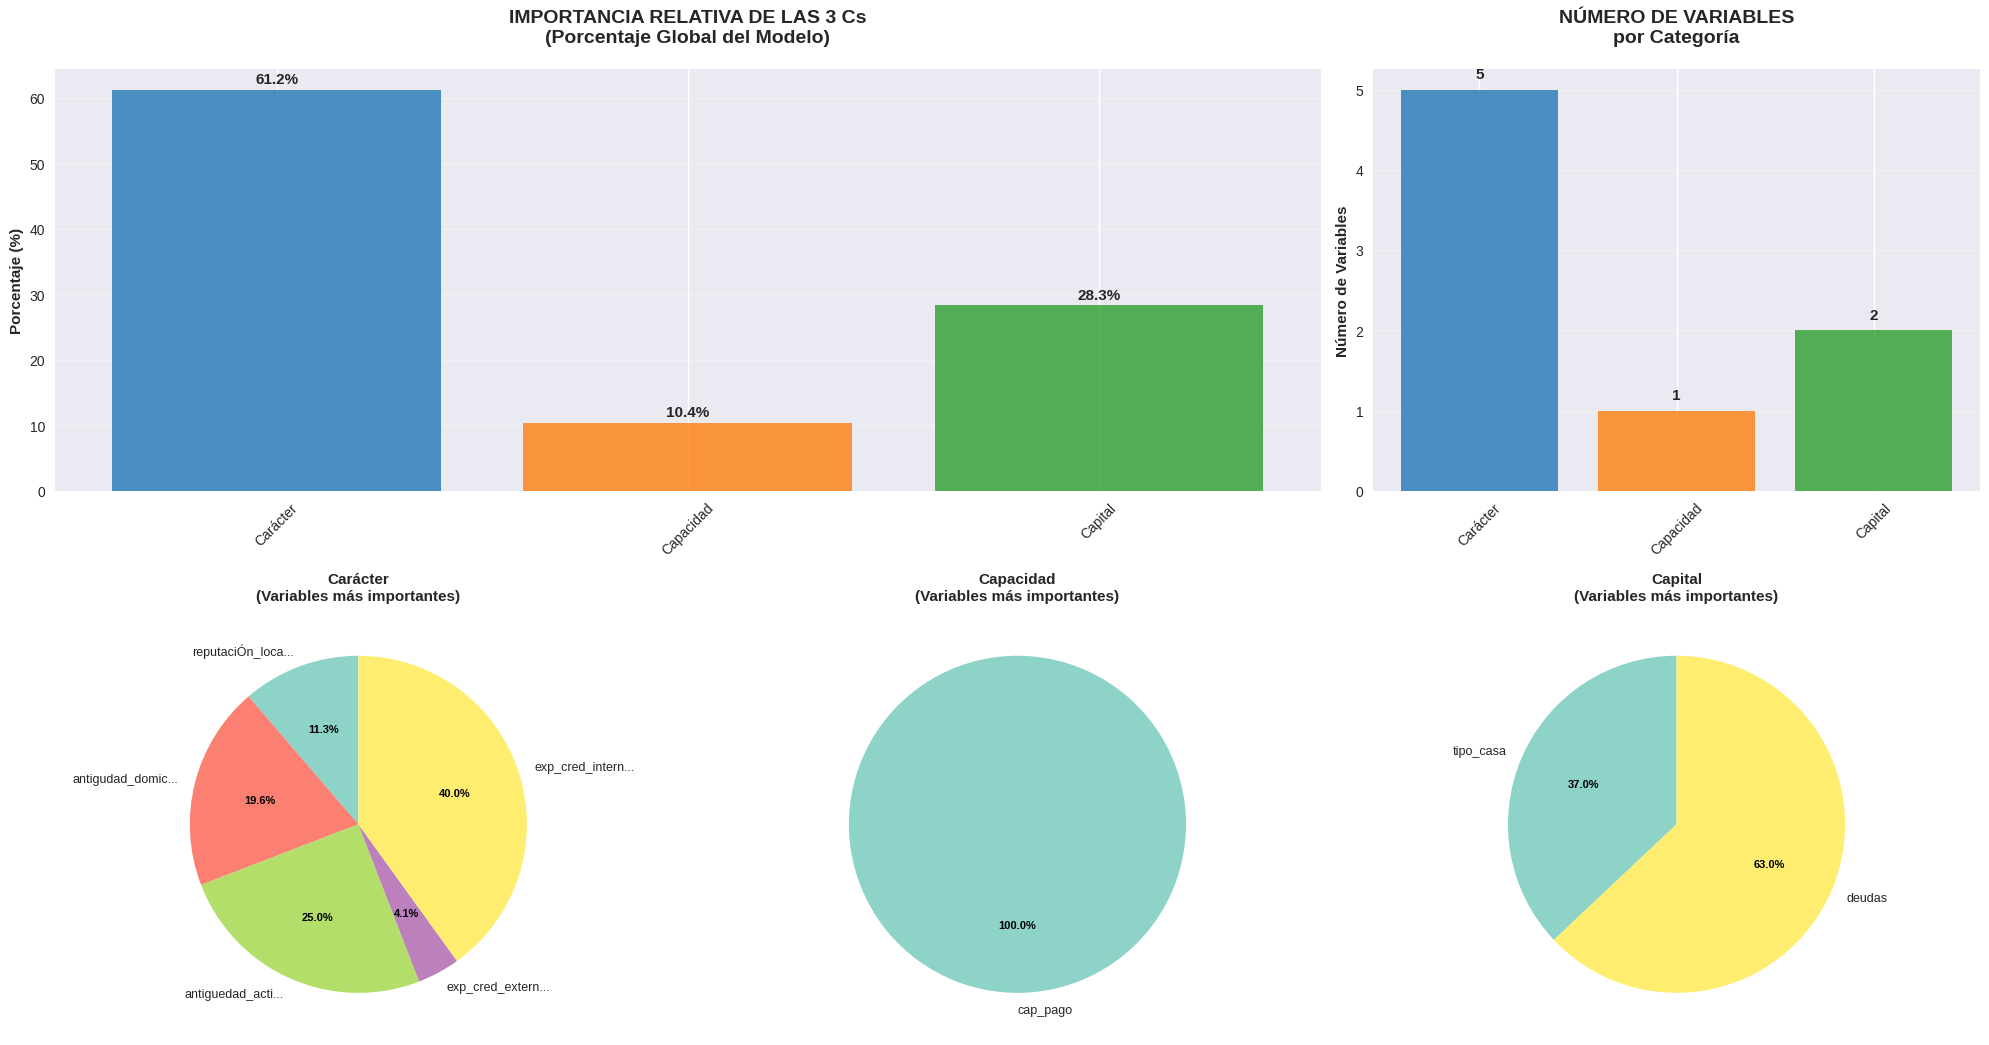


📋 RESUMEN DETALLADO POR VARIABLE

🔍 CARÁCTER (61.2% del total)
--------------------------------------------------------------------------------
  ⭐⭐ exp_cred_interna:
     📊 Importancia: 0.020603
     📈 Porcentaje dentro de Carácter: 40.0%
     🔢 Características: 3
     🎯 Features principales: exp_cred_interna_HASTA 5 ATRASOS DE 8 A 15 DIAS (CALIF. C), exp_cred_interna_HASTA 5 ATRASOS MENORES DE 7 DIAS(CALIF. B), exp_cred_interna_PAGO PUNTUAL(CALIF. A)

  ⭐ antiguedad_actividad:
     📊 Importancia: 0.012868
     📈 Porcentaje dentro de Carácter: 25.0%
     🔢 Características: 3
     🎯 Features principales: antiguedad_actividad_MAYOR DE 5 AÑOS, antiguedad_actividad_DE 3 A 5 AÑOS, antiguedad_actividad_MENOR A 1 AÑO

  ⭐ antigudad_domicilio:
     📊 Importancia: 0.010066
     📈 Porcentaje dentro de Carácter: 19.6%
     🔢 Características: 3
     🎯 Features principales: antigudad_domicilio_MAYOR DE 5 AÑOS, antigudad_domicilio_DE 4 A 5 AÑOS, antigudad_domicilio_MENOR DE 1 AÑO

  ⭐ reputaciÓn_l

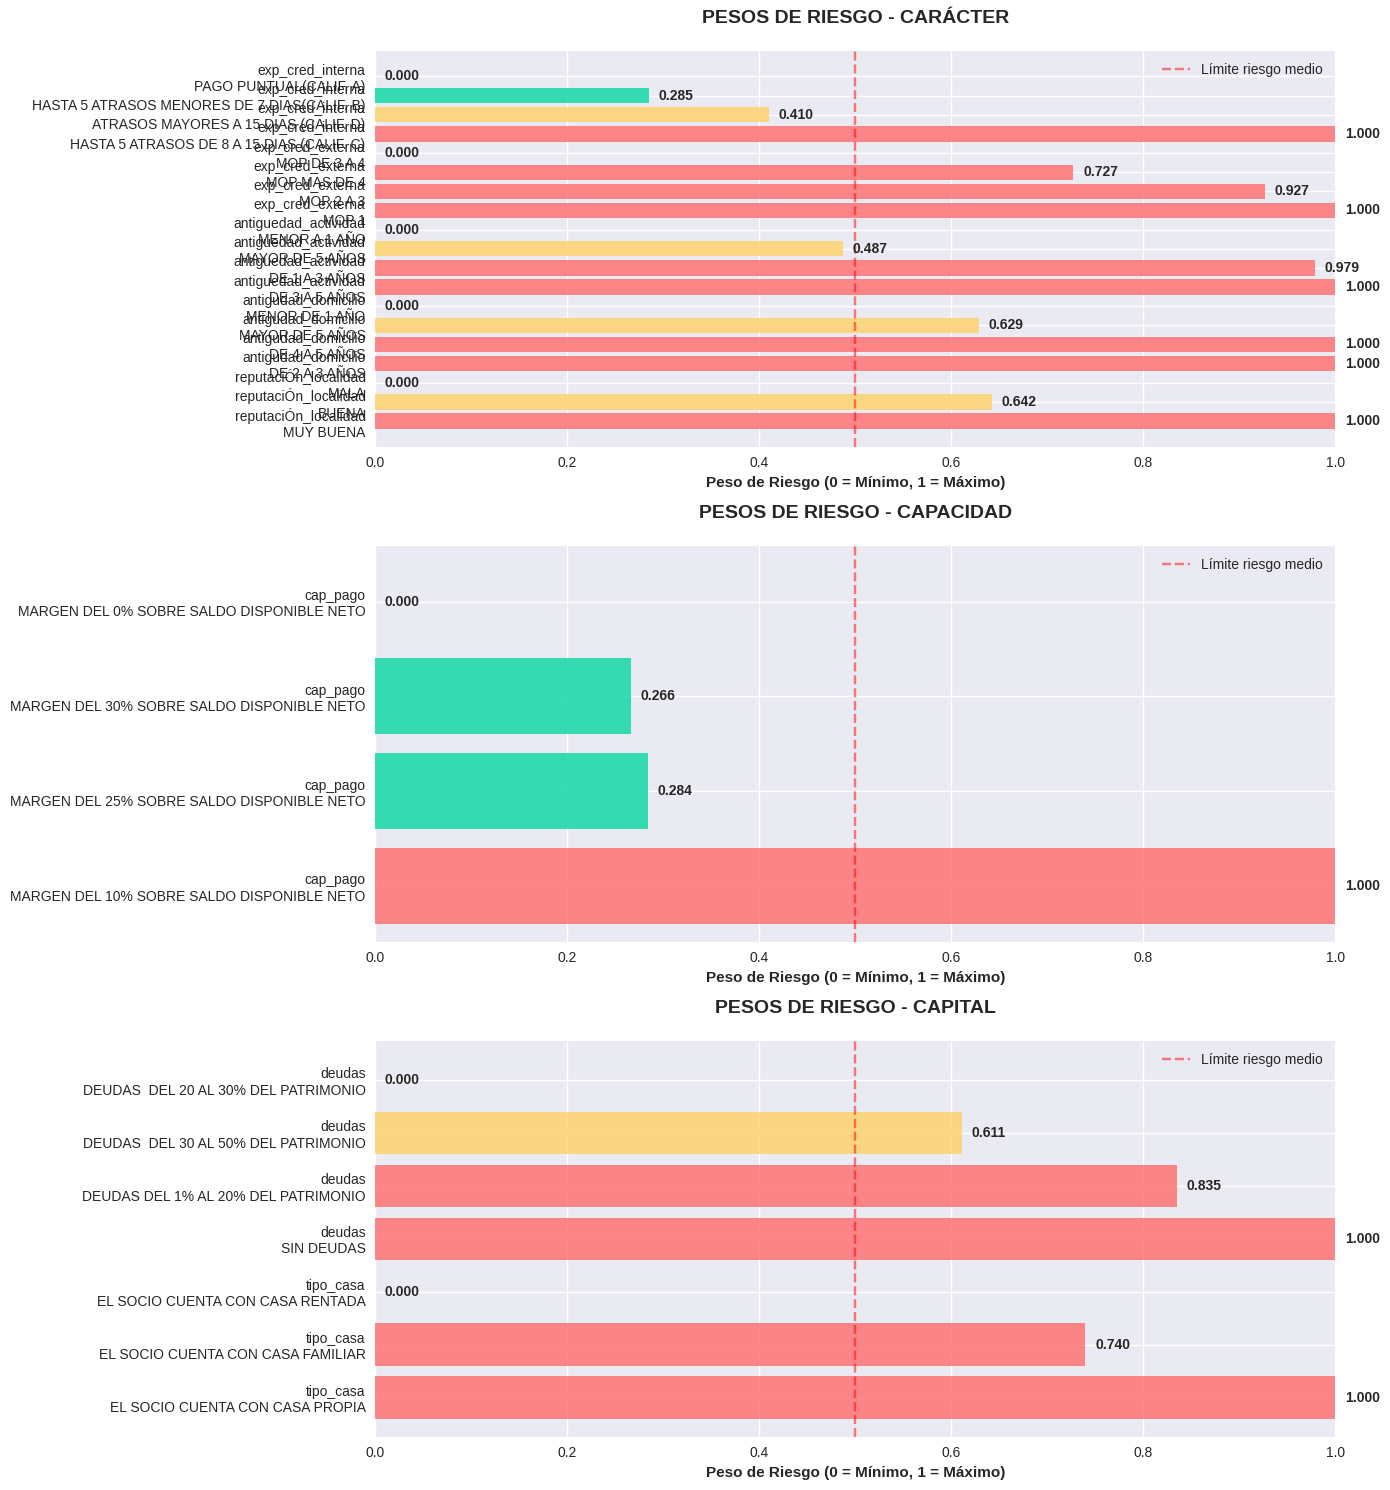

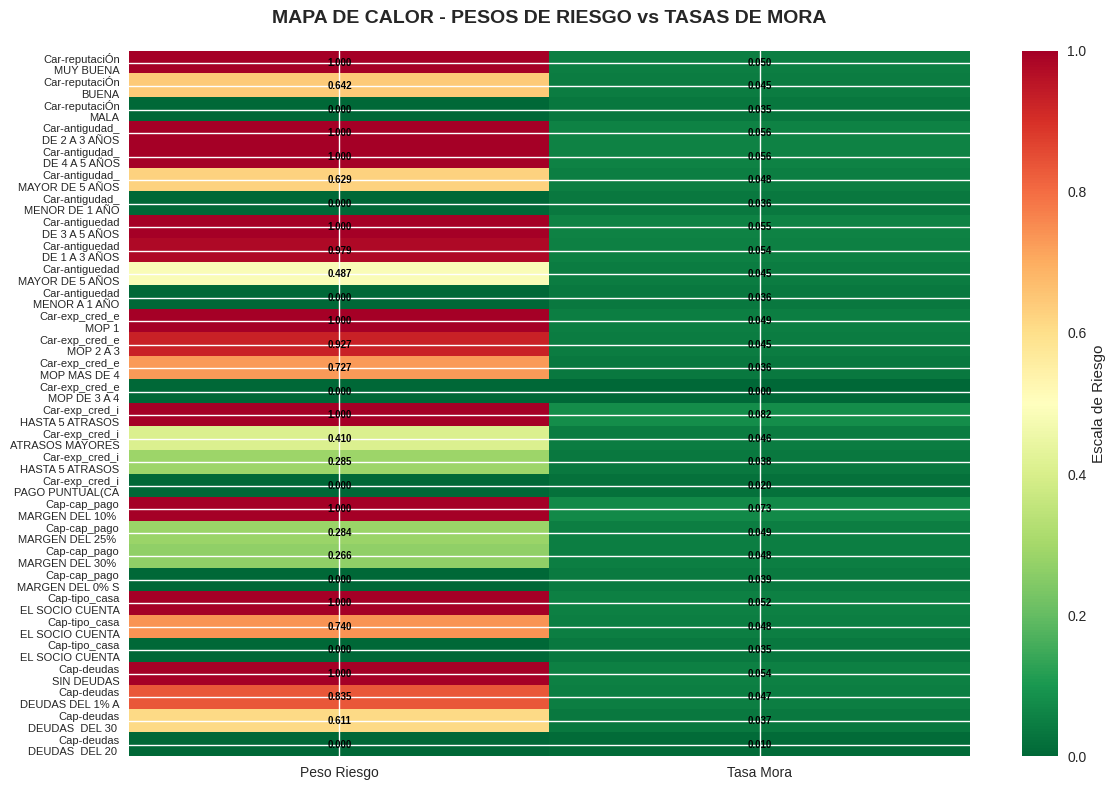


💾 Exportando resultados a analisis_5cs_completo.xlsx...
✅ Resultados exportados exitosamente a: analisis_5cs_completo.xlsx

💾 Exportando pesos detallados a pesos_detallados_5cs.xlsx...
✅ Pesos detallados exportados exitosamente a: pesos_detallados_5cs.xlsx

🎯 RESUMEN EJECUTIVO COMPLETO
📊 Categoría más importante: Carácter (61.2%)
⭐ Variable más importante: exp_cred_interna (Carácter)

⚠️  VALORES MÁS RIESGOSOS POR CATEGORÍA:
   🔴 Carácter - reputaciÓn_localidad: 'MUY BUENA' (Peso: 1.000, Tasa: 5.0%)
   🔴 Carácter - antigudad_domicilio: 'DE 2 A 3 AÑOS' (Peso: 1.000, Tasa: 5.6%)
   🔴 Carácter - antiguedad_actividad: 'DE 3 A 5 AÑOS' (Peso: 1.000, Tasa: 5.5%)
   🔴 Carácter - exp_cred_externa: 'MOP 1' (Peso: 1.000, Tasa: 4.9%)
   🔴 Carácter - exp_cred_interna: 'HASTA 5 ATRASOS DE 8 A 15 DIAS (CALIF. C)' (Peso: 1.000, Tasa: 8.2%)
   🔴 Capacidad - cap_pago: 'MARGEN DEL 10% SOBRE SALDO DISPONIBLE NETO' (Peso: 1.000, Tasa: 7.3%)
   🔴 Capital - tipo_casa: 'EL SOCIO CUENTA CON CASA PROPIA' (Peso

In [120]:
# Cargar tus datos (asegúrate de que df esté definido)
df = LeerBaseDatos()  # Descomenta si necesitas cargar los datos

# Ejecutar análisis completo
try:
    #df_enhanced, resultados, feature_importance = analisis_completo_5cs(df)
    df_enhanced, resultados, feature_importance = analisis_completo_5cs_con_pesos(df)
    #resultados = analisis_completo_pesos_normalizados(df)
    #resultados = analisis_completo_con_exportacion(df)
    print("\n✅ ANÁLISIS COMPLETADO EXITOSAMENTE")
except Exception as e:
    print(f"❌ Error en el análisis: {e}")
    print("💡 Asegúrate de que el DataFrame 'df' esté cargado correctamente")

In [121]:
# Cargar tus datos (asegúrate de que df esté definido)
df = LeerBaseDatos()  # Descomenta si necesitas cargar los datos
# Ejecutar análisis completo
try:
    #df_enhanced, resultados, feature_importance = analisis_completo_5cs(df)
    #df_enhanced, resultados, feature_importance = analisis_completo_5cs_con_pesos(df)
    sistema, pesos, ejemplo = analisis_completo_con_scoring(df)
    print("\n✅ ANÁLISIS COMPLETADO EXITOSAMENTE")
except Exception as e:
    print(f"❌ Error en el análisis: {e}")
    print("💡 Asegúrate de que el DataFrame 'df' esté cargado correctamente")

🚀 INICIANDO ANÁLISIS COMPLETO CON SISTEMA DE SCORING
🔧 Aplicando Feature Engineering para riesgo crediticio...
   - Creando ratios financieros...
   - Creando scores de historial crediticio...
   - Creando variables de estabilidad...
   - Calculando scores compuestos...
✅ Feature engineering completado
   Nuevas variables creadas: 16

🎯 CREANDO SISTEMA DE SCORING ROBUSTO

📊 Carácter:
----------------------------------------
  🔸 reputaciÓn_localidad:
     ⚠️  Valor 'REGULAR' no encontrado en datos - estimando...
❌ Error en el análisis: name 'self' is not defined
💡 Asegúrate de que el DataFrame 'df' esté cargado correctamente
